___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

## Overview

In this project, we will use The 2012 US Army Anthropometric Survey (ANSUR II) dataset [1] to predict the race of soldiers. The dataset consists of anthropometric and demographic data for both female and male soldiers. The ANSUR II dataset is a comprehensive collection of measurements and information gathered from a diverse population of soldiers. It includes a wide range of features such as height, weight, body circumference, limb lengths, facial measurements, and demographic attributes like age, gender, and ethnicity. In addition, we created a schema for easy mapping between the features and thier description. By leveraging this data, we aim to develop a model that can accurately classify the race of a soldier, using various algorithms capable of handling multiclass classification.


# Tasks

#### 1. Exploratory Data Analysis (EDA)
- Import Libraries, Load Dataset, Exploring Data

    *i. Import Libraries*
    
    *ii. Ingest Data *
    
    *iii. Explore Data*
    
    *iv. Outlier Detection*
    
    *v.  Drop unnecessary features*

#### 2. Data Preprocessing
- Scale (if needed)
- Separete the data frame for evaluation purposes

#### 3. Multi-class Classification
- Import libraries
- Implement SVM Classifer
- Implement Decision Tree Classifier
- Implement Random Forest Classifer
- Implement XGBoost Classifer
- Compare The Models



# EDA

In this section we will combine the female and malae datasets into one harmonized dataframe, examine the features, visualize the relationships, and drop irrelevant information.

In [135]:
#importing the libraries

import numpy as np
import pandas as pd
from numpy import mean
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint 

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay,RocCurveDisplay
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV
from scikitplot.metrics import plot_roc, plot_precision_recall
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score
import shap
import warnings

warnings.filterwarnings('ignore') 
sns.set_style('whitegrid')
pd.set_option('display.max_rows', None)

%matplotlib inline

### Combining the two datasets

In [3]:
df1 = pd.read_csv('ANSUR II MALE Public.csv', encoding = 'Latin-1')

In [4]:
df2 = pd.read_csv('ANSUR II FEMALE Public.csv', encoding = 'Latin-1')

In [5]:
# check if they have the same columns
set(df1.columns) == set(df2.columns)

False

In [6]:
# print uncommon items
set(df1.columns) ^ (set(df2.columns))

{'SubjectId', 'subjectid'}

In [7]:
df1.rename(columns={'subjectid': 'SubjectId'}, inplace=True)

In [8]:
set(df1.columns) == set(df2.columns)

True

In [9]:
df = pd.concat([df1, df2], axis = 0)

In [10]:
df.sample(2)

SubjectId  abdominalextensiondepthsitting  acromialheight  \
2338      21438                             251            1472   
193       11142                             308            1435   

      acromionradialelength  anklecircumference  axillaheight  \
2338                    349                 220          1358   
193                     327                 233          1326   

      balloffootcircumference  balloffootlength  biacromialbreadth  \
2338                      242               203                390   
193                       265               214                438   

      bicepscircumferenceflexed  ...                  Branch  PrimaryMOS  \
2338                        310  ...  Combat Service Support         15T   
193                         429  ...  Combat Service Support         91L   

      SubjectsBirthLocation  SubjectNumericRace  Ethnicity  DODRace  Age  \
2338             New Mexico                   1        NaN        1   23   
193             Mississippi                   2        NaN        2   24   

      Heightin  Weightlbs  WritingPreference  
2338        71        160         Right hand  
193         70        228         Right hand  

[2 rows x 108 columns]

## Schema

In [11]:
schema = pd.read_csv('ANSUR II Databases Overview.csv')
schema.head()

feature                                        description  \
0             SubjectId  A unique number for each participant measured ...   
1  SubjectBirthLocation  Subject Birth Location; a U.S. state or foreig...   
2    SubjectNumericRace  Subject Numeric Race; a single or multi-digit ...   
3             Ethnicity  self-reported ethnicity (verified through inte...   
4               DODRace  Department of Defense Race; a single digit ind...   

               type  
0  Demographic data  
1  Demographic data  
2  Demographic data  
3  Demographic data  
4  Demographic data

In [12]:
# removing the spaces from str
schema['feature'] = schema['feature'].str.strip()

In [13]:
def mapping(feature):
    '''
    Description:
    This function gets a column and map back its original description.
    
    INPUT:
    feature - (str) column name as a string
    
    OUTPUT:
    desc - (str) full description
    '''
    desc = list(schema[schema['feature'] == feature]['description'])
    return desc

In [14]:
# using pprint for better readability
pprint(mapping('Ethnicity'))

['self-reported ethnicity (verified through interview); e.g. “Mexican”, '
 '“Vietnamese”']


## Dropping columns with too many nulls

In [15]:
cols = set(df.columns)

In [16]:
#to handle missing values drop any columns that exceeds the threshold value

threshold = 0.5 # 50%
df = df.loc[:, df.isna().mean().lt(threshold)]

In [17]:
# show dropped columns
dropped = cols ^ set(df.columns)
list(dropped)

['Ethnicity']

## Dropping redundant/irrelevant features

In this section the features were mostly examined manually 

In [18]:
schema

feature  \
0                         SubjectId   
1              SubjectBirthLocation   
2                SubjectNumericRace   
3                         Ethnicity   
4                           DODRace   
5                            Gender   
6                               Age   
7                          Heightin   
8                         Weightlbs   
9                 WritingPreference   
10                             Date   
11                     Installation   
12                        Component   
13                           Branch   
14                       PrimaryMOS   
15                             NOTE   
16   abdominalextensiondepthsitting   
17                   acromialheight   
18            acromionradialelength   
19               anklecircumference   
20                     axillaheight   
21          balloffootcircumference   
22                 balloffootlength   
23                biacromialbreadth   
24        bicepscircumferenceflexed   
25                 bicristalbreadth   
26                 bideltoidbreadth   
27               bimalleolarbreadth   
28                 bitragionchinarc   
29        bitragionsubmandibulararc   
30               bizygomaticbreadth   
31             buttockcircumference   
32                     buttockdepth   
33                    buttockheight   
34                buttockkneelength   
35           buttockpopliteallength   
36                calfcircumference   
37                  cervicaleheight   
38                     chestbreadth   
39               chestcircumference   
40                       chestdepth   
41                      chestheight   
42                     crotchheight   
43            crotchlengthomphalion   
44   crotchlengthposterioromphalion   
45                       earbreadth   
46                        earlength   
47                    earprotrusion   
48                  elbowrestheight   
49                 eyeheightsitting   
50            footbreadthhorizontal   
51                       footlength   
52        forearmcenterofgriplength   
53       forearmcircumferenceflexed   
54            forearmforearmbreadth   
55                forearmhandlength   
56              functionalleglength   
57                      handbreadth   
58                handcircumference   
59                       handlength   
60                      headbreadth   
61                headcircumference   
62                       headlength   
63           heelanklecircumference   
64                      heelbreadth   
65                       hipbreadth   
66                hipbreadthsitting   
67               iliocristaleheight   
68            interpupillarybreadth   
69                       interscyei   
70                      interscyeii   
71             kneeheightmidpatella   
72                kneeheightsitting   
73   lateralfemoralepicondyleheight   
74           lateralmalleolusheight   
75          lowerthighcircumference   
76              mentonsellionlength   
77                neckcircumference   
78            neckcircumferencebase   
79    overheadfingertipreachsitting   
80                       palmlength   
81                  poplitealheight   
82             radialestylionlength   
83            shouldercircumference   
84              shoulderelbowlength   
85                   shoulderlength   
86                    sittingheight   
87           sleevelengthspinewrist   
88                    sleeveoutseam   
89                             span   
90                          stature   
91              suprasternaleheight   
92                   tenthribheight   
93               thighcircumference   
94                   thighclearance   
95                    thumbtipreach   
96                     tibialheight   
97                 tragiontopofhead   
98              trochanterionheight   
99    verticaltrunkcircumferenceusa   
100                 waistbacklength   
101                    waistbreadth   
102        

In [19]:
df['SubjectsBirthLocation'].value_counts()

California                  446
New York                    420
Texas                       397
Indiana                     266
Oklahoma                    221
Illinois                    216
Florida                     210
Minnesota                   200
Michigan                    196
Mississippi                 194
Georgia                     170
Alabama                     164
South Carolina              161
North Carolina              149
Ohio                        142
Louisiana                   137
Pennsylvania                132
Virginia                    118
Massachusetts               112
Wisconsin                   102
Germany                      92
New Jersey                   89
Puerto Rico                  88
Arizona                      84
Missouri                     84
Colorado                     81
Maryland                     80
Tennessee                    74
Kentucky                     69
Washington                   66
Kansas                       63
South Da

In [20]:
pprint(mapping('SubjectNumericRace'))

['Subject Numeric Race; a single or multi-digit code indicating a subject’s '
 'self-reported race or races (verified through interview). Where 1 = White, 2 '
 '= Black, 3 = Hispanic, 4 = Asian, 5 = Native American, 6 = Pacific Islander, '
 '8 = Other']


In [21]:
mapping('Weightlbs')

['Weight in Pounds; self-reported, comparable to measured “weightkg”']

In [22]:
mapping('Heightin')

['Height in Inches; self-reported, comparable to measured “stature”']

In [23]:
# count of each combination of categories between the Component and DODRace 
ct = pd.crosstab( df['Component'],df['DODRace'], margins=True, margins_name="Total", normalize='index')
ct

DODRace                     1         2         3         4         5  \
Component                                                               
Army National Guard  0.685007  0.184269  0.093427  0.022157  0.008863   
Army Reserve         0.518182  0.236364  0.186364  0.040909  0.004545   
Regular Army         0.580573  0.237898  0.122611  0.037898  0.007643   
Total                0.624918  0.213909  0.111898  0.030982  0.008075   

DODRace                     6         8  
Component                                
Army National Guard  0.006278  0.000000  
Army Reserve         0.013636  0.000000  
Regular Army         0.012420  0.000955  
Total                0.009723  0.000494

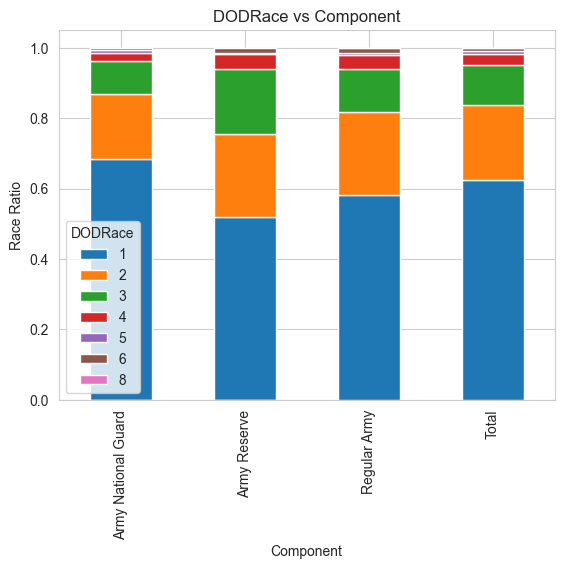

In [24]:
ct.plot(kind='bar', stacked=True)
plt.title('DODRace vs Component')
plt.xlabel('Component')
plt.ylabel('Race Ratio')
plt.show()

In [25]:
# count of each combination of categories between the Branch and DODRace 
ct2 = pd.crosstab( df['Branch'],df['DODRace'], margins=True, margins_name="Total", normalize='index')
ct2

DODRace                        1         2         3         4         5  \
Branch                                                                     
Combat Arms             0.724399  0.109355  0.119469  0.027813  0.010114   
Combat Service Support  0.602079  0.234720  0.114997  0.031191  0.007876   
Combat Support          0.560213  0.289634  0.095274  0.034299  0.006098   
Total                   0.624918  0.213909  0.111898  0.030982  0.008075   

DODRace                        6         8  
Branch                                      
Combat Arms             0.008217  0.000632  
Combat Service Support  0.008507  0.000630  
Combat Support          0.014482  0.000000  
Total                   0.009723  0.000494

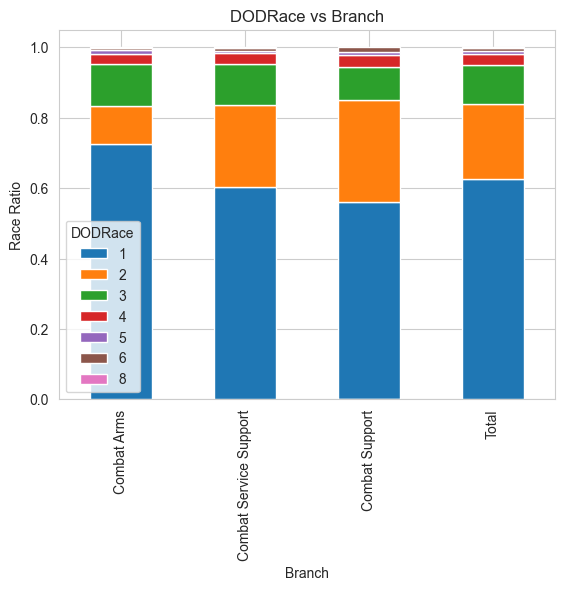

In [26]:
ct2.plot(kind='bar', stacked=True)
plt.title('DODRace vs Branch')
plt.xlabel('Branch')
plt.ylabel('Race Ratio')
plt.show()

The Component and Branch features were mostly dominated by white race and no much information can be driven to identify race based on these two

In [27]:
features_to_drop = [ 
    'SubjectId', # irrelavant
    'SubjectNumericRace', # redundant
    'Heightin', # redundant
    'Weightlbs',  # redundant
    'Date',  # irrelavant
    'Installation',  # irrelavant
    'PrimaryMOS', # irrelavant
    'Component', # irrelavant
    'Branch', # irrelavant
    # 'WritingPreference', # there are some studies about its association with race so I'm not drpping it
    ]

In [28]:
# dropping the features
df = df.drop(features_to_drop, axis=1)

### Feature Engineering

In [29]:
# This is a dictionary of states and their regions.
states_by_region = {
    "Alabama": "South",
    "Alaska": "West",
    "Arizona": "West",
    "Arkansas": "South",
    "California": "West",
    "Colorado": "West",
    "Connecticut": "Northeast",
    "Delaware": "Mid Atlantic",
    "Florida": "South",
    "Georgia": "South",
    "Hawaii": "West",
    "Idaho": "West",
    "Illinois": "Midwest",
    "Indiana": "Midwest",
    "Iowa": "Midwest",
    "Kansas": "Midwest",
    "Kentucky": "South",
    "Louisiana": "South",
    "Maine": "Northeast",
    "Maryland": "Mid Atlantic",
    "Massachusetts": "Northeast",
    "Michigan": "Midwest",
    "Minnesota": "Midwest",
    "Mississippi": "South",
    "Missouri": "Midwest",
    "Montana": "West",
    "Nebraska": "Midwest",
    "Nevada": "West",
    "New Hampshire": "Northeast",
    "New Jersey": "Mid Atlantic",
    "New Mexico": "West",
    "New York": "Northeast",
    "North Carolina": "South",
    "North Dakota": "Midwest",
    "Ohio": "Midwest",
    "Oklahoma": "South",
    "Oregon": "West",
    "Pennsylvania": "Mid Atlantic",
    "Rhode Island": "Northeast",
    "South Carolina": "South",
    "South Dakota": "Midwest",
    "Tennessee": "South",
    "Texas": "South",
    "Utah": "West",
    "Vermont": "Northeast",
    "Virginia": "Mid Atlantic",
    "Washington": "West",
    "West Virginia": "South",
    "Wisconsin": "Midwest",
    "Wyoming": "West",
    "District of Columbia": "Mid Atlantic"
}


In [30]:
# This is a dictionary of the countries and their continents.
countries_by_continent = {
    "Afghanistan": "Asia",
    "Albania": "Europe",
    "Algeria": "Africa",
    "American Samoa": "Oceania",
    "Andorra": "Europe",
    "Angola": "Africa",
    "Antigua and Barbuda": "North America",
    "Argentina": "South America",
    "Armenia": "Asia",
    "Australia": "Oceania",
    "Austria": "Europe",
    "Azerbaijan": "Asia",
    "Bahamas": "North America",
    "Bahrain": "Asia",
    "Bangladesh": "Asia",
    "Barbados": "North America",
    "Belarus": "Europe",
    "Belgium": "Europe",
    "Belize": "North America",
    "Benin": "Africa",
    "Bhutan": "Asia",
    "Bolivia": "South America",
    "Bosnia and Herzegovina": "Europe",
    "Botswana": "Africa",
    "Brazil": "South America",
    "British Virgin Islands": "North America",
    "Brunei": "Asia",
    "Bulgaria": "Europe",
    "Burkina Faso": "Africa",
    "Burundi": "Africa",
    "Cambodia": "Asia",
    "Cameroon": "Africa",
    "Canada": "North America",
    "Cape Verde": "Africa",
    "Central African Republic": "Africa",
    "Chad": "Africa",
    "Chile": "South America",
    "China": "Asia",
    "Colombia": "South America",
    "Comoros": "Africa",
    "Congo, Democratic Republic of the": "Africa",
    "Congo, Republic of the": "Africa",
    "Costa Rica": "North America",
    "Côte d'Ivoire": "Africa",
    "Croatia": "Europe",
    "Cuba": "North America",
    "Cyprus": "Europe",
    "Czech Republic": "Europe",
    "Denmark": "Europe",
    "Djibouti": "Africa",
    "Dominica": "North America",
    "Dominican Republic": "North America",
    "East Timor": "Asia",
    "Ecuador": "South America",
    "Egypt": "Africa",
    "El Salvador": "North America",
    "England": "Europe",
    "Equatorial Guinea": "Africa",
    "Eritrea": "Africa",
    "Estonia": "Europe",
    "Eswatini": "Africa",
    "Ethiopia": "Africa",
    "Federated States of Micronesia": "Oceania",
    "Fiji": "Oceania",
    "Finland": "Europe",
    "France": "Europe",
    "French Guiana": "South America",
    "Gabon": "Africa",
    "Gambia": "Africa",
    "Georgia": "Asia",
    "Germany": "Europe",
    "Ghana": "Africa",
    "Greece": "Europe",
    "Grenada": "North America",
    "Guam": "Oceania",
    "Guadalupe" : "North America",
    "Guatemala": "North America",
    "Guinea": "Africa",
    "Guinea-Bissau": "Africa",
    "Guyana": "South America",
    "Haiti": "North America",
    "Honduras": "North America",
    "Hungary": "Europe",
    "Iceland": "Europe",
    "India": "Asia",
    "Indonesia": "Asia",
    "Iran": "Asia",
    "Iraq": "Asia",
    "Ireland": "Europe",
    "Israel": "Asia",
    "Italy": "Europe",
    "Ivory Coast": "Africa",
    "Jamaica": "North America",
    "Japan": "Asia",
    "Jordan": "Asia",
    "Kazakhstan": "Asia",
    "Kenya": "Africa",
    "Kiribati": "Oceania",
    "Kosovo": "Europe",
    "Kuwait": "Asia",
    "Kyrgyzstan": "Asia",
    "Laos": "Asia",
    "Latvia": "Europe",
    "Lebanon": "Asia",
    "Lesotho": "Africa",
    "Liberia": "Africa",
    "Libya": "Africa",
    "Liechtenstein": "Europe",
    "Lithuania": "Europe",
    "Luxembourg": "Europe",
    "Macedonia, Republic of": "Europe",
    "Madagascar": "Africa",
    "Malawi": "Africa",
    "Malaysia": "Asia",
    "Maldives": "Asia",
    "Mali": "Africa",
    "Malta": "Europe",
    "Marshall Islands": "Oceania",
    "Mauritania": "Africa",
    "Mauritius": "Africa",
    "Mexico": "North America",
    "Micronesia": "Oceania",
    "Moldova": "Europe",
    "Monaco": "Europe",
    "Mongolia": "Asia",
    "Montenegro": "Europe",
    "Morocco": "Africa",
    "Mozambique": "Africa",
    "Myanmar (Burma)": "Asia",
    "Namibia": "Africa",
    "Nauru": "Oceania",
    "Nepal": "Asia",
    "Netherlands": "Europe",
    "New Zealand": "Oceania",
    "Nicaragua": "North America",
    "Niger": "Africa",
    "Nigeria": "Africa",
    "North Korea": "Asia",
    "Norway": "Europe",
    "Oman": "Asia",
    "Pakistan": "Asia",
    "Palau": "Oceania",
    "Palestine": "Asia",
    "Panama": "North America",
    "Papua New Guinea": "Oceania",
    "Paraguay": "South America",
    "Peru": "South America",
    "Philippines": "Asia",
    "Poland": "Europe",
    "Portugal": "Europe",
    "Puerto Rico": "North America",
    "Qatar": "Asia",
    "Romania": "Europe",
    "Russia": "Europe",
    "Rwanda": "Africa",
    "Saint Kitts and Nevis": "North America",
    "Saint Lucia": "North America",
    "Saint Vincent and the Grenadines": "North America",
    "Samoa": "Oceania",
    "San Marino": "Europe",
    "Sao Tome and Principe": "Africa",
    "Saudi Arabia": "Asia",
    "Scotland": "Europe",
    "Senegal": "Africa",
    "Serbia": "Europe",
    "Seychelles": "Africa",
    "Sierra Leone": "Africa",
    "Singapore": "Asia",
    "Slovakia": "Europe",
    "Slovenia": "Europe",
    "Solomon Islands": "Oceania",
    "Somalia": "Africa",
    "South Africa": "Africa",
    "South Korea": "Asia",
    "South Sudan": "Africa",
    "Spain": "Europe",
    "Sri Lanka": "Asia",
    "Sudan": "Africa",
    "Suriname": "South America",
    "Swaziland": "Africa",
    "Sweden": "Europe",
    "Switzerland": "Europe",
    "Syria": "Asia",
    "Taiwan": "Asia",
    "Tajikistan": "Asia",
    "Tanzania": "Africa",
    "Thailand": "Asia",
    "Togo": "Africa",
    "Tonga": "Oceania",
    "Trinidad and Tobago": "North America",
    "Tunisia": "Africa",
    "Turkey": "Europe",
    "Turkmenistan": "Asia",
    "Tuvalu": "Oceania",
    "Uganda": "Africa",
    "Ukraine": "Europe",
    "United Arab Emirates": "Asia",
    "United Kingdom": "Europe",
    "United States": "North America",
    "Uruguay": "South America",
    "US Virgin Islands": "North America",
    "Uzbekistan": "Asia",
    "Vanuatu": "Oceania",
    "Vatican City": "Europe",
    "Venezuela": "South America",
    "Vietnam": "Asia",
    "Wales": "Europe",
    "Yemen": "Asia",
    "Zambia": "Africa",
    "Zimbabwe": "Africa",
    "South America": "South America",
    "Burma": "Asia",
    "Korea": "Asia",
    "Northern Mariana Islands": "Oceania",
    "Bermuda": "North America",
}


In [31]:
# mapping each state to its country and each country to its continent
# doing this step will reduce the number of columns after transformation 

df["SubjectsBirthLocation"] = [i if i in states_by_region else countries_by_continent[i] for i in df["SubjectsBirthLocation"].values ]
df["SubjectsBirthLocation"].value_counts()

California              446
New York                420
Texas                   397
Indiana                 266
North America           265
Oklahoma                221
Illinois                216
Florida                 210
Minnesota               200
Michigan                196
Mississippi             194
Georgia                 170
Alabama                 164
South Carolina          161
North Carolina          149
Europe                  149
Asia                    144
Ohio                    142
Louisiana               137
Pennsylvania            132
Virginia                118
Massachusetts           112
Wisconsin               102
New Jersey               89
Missouri                 84
Arizona                  84
Colorado                 81
Maryland                 80
Tennessee                74
Kentucky                 69
Washington               66
Kansas                   63
South Dakota             56
Iowa                     55
Arkansas                 54
South America       

In [87]:
# diffirent approach - drop values with count less than 50

counts = df['SubjectsBirthLocation'].value_counts()

values_to_drop = counts[counts <= 50]

mask = df['SubjectsBirthLocation'].isin(values_to_drop.index)

# keep the rows where the mask is False
df = df[~mask]

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6068 entries, 0 to 1985
Data columns (total 98 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   abdominalextensiondepthsitting  6068 non-null   int64 
 1   acromialheight                  6068 non-null   int64 
 2   acromionradialelength           6068 non-null   int64 
 3   anklecircumference              6068 non-null   int64 
 4   axillaheight                    6068 non-null   int64 
 5   balloffootcircumference         6068 non-null   int64 
 6   balloffootlength                6068 non-null   int64 
 7   biacromialbreadth               6068 non-null   int64 
 8   bicepscircumferenceflexed       6068 non-null   int64 
 9   bicristalbreadth                6068 non-null   int64 
 10  bideltoidbreadth                6068 non-null   int64 
 11  bimalleolarbreadth              6068 non-null   int64 
 12  bitragionchinarc                6068 non-null   

## Explore Data

In [32]:
# checking for null values
df.isnull().sum().any()

False

In [33]:
# checking for duplicates
df.duplicated().sum()

0

In [34]:
df.describe().T

count         mean         std     min  \
abdominalextensiondepthsitting  6068.0   246.468688   37.400106   155.0   
acromialheight                  6068.0  1406.161338   79.091048  1115.0   
acromionradialelength           6068.0   327.374423   20.720018   249.0   
anklecircumference              6068.0   224.891397   16.051833   156.0   
axillaheight                    6068.0  1299.608767   72.022286  1038.0   
balloffootcircumference         6068.0   244.192650   16.845020   186.0   
balloffootlength                6068.0   194.754614   13.516368   151.0   
biacromialbreadth               6068.0   399.204186   30.236914   283.0   
bicepscircumferenceflexed       6068.0   340.934245   41.519866   216.0   
bicristalbreadth                6068.0   274.735003   19.221034   197.0   
bideltoidbreadth                6068.0   490.754450   42.135535   357.0   
bimalleolarbreadth              6068.0    72.252637    5.344590    55.0   
bitragionchinarc                6068.0   324.896506   17.087501   267.0   
bitragionsubmandibulararc       6068.0   306.636124   20.794166   245.0   
bizygomaticbreadth              6068.0   139.723467    7.308457   116.0   
buttockcircumference            6068.0  1020.084707   76.422643   737.0   
buttockdepth                    6068.0   241.619974   26.482986   168.0   
buttockheight                   6068.0   870.152274   54.822574   656.0   
buttockkneelength               6068.0   608.999176   33.792839   466.0   
buttockpopliteallength          6068.0   497.097561   29.082390   367.0   
calfcircumference               6068.0   386.041200   30.647180   266.0   
cervicaleheight                 6068.0  1477.490442   84.323707  1184.0   
chestbreadth                    6068.0   282.859097   20.659397   213.0   
chestcircumference              6068.0  1022.098879  100.671751   695.0   
chestdepth                      6068.0   251.738464   26.777843   170.0   
chestheight                     6068.0  1252.013184   79.583972   984.0   
crotchheight                    6068.0   825.110086   54.748240   610.0   
crotchlengthomphalion           6068.0   621.851681   45.332961   473.0   
crotchlengthposterioromphalion  6068.0   351.315920   29.944868   243.0   
earbreadth                      6068.0    35.132169    3.231469    25.0   
earlength                       6068.0    62.625906    4.876264    46.0   
earprotrusion                   6068.0    22.263349    3.172715    13.0   
elbowrestheight                 6068.0   240.911338   28.509447   138.0   
eyeheightsitting                6068.0   785.914469   41.865795   654.0   
footbreadthhorizontal           6068.0    98.865359    6.657916    77.0   
footlength                      6068.0   263.033619   17.390971   198.0   
forearmcenterofgriplength       6068.0   338.766645   23.244742   258.0   
forearmcircumferenceflexed      6068.0   295.010712   30.049715   200.0   
forearmforearmbreadth           6068.0   552.075972   62.368049   376.0   
forearmhandlength               6068.0   467.007086   30.034820   342.0   
functionalleglength             6068.0  1102.049275   68.545784   835.0   
handbreadth                     6068.0    84.953362    6.346510    67.0   
handcircumference               6068.0   203.861404   15.551424   152.0   
handlength                      6068.0   189.286585   11.505788   145.0   
headbreadth                     6068.0   152.182762    6.235692   131.0   
headcircumference               6068.0   570.035267   18.291139   500.0   
headlength                      6068.0   196.334871    8.485374   168.0   
heelanklecircumference          6068.0   332.622940   22.460776   258.0   
heelbreadth                     6068.0    70.756922    5.932626    48.0   
hipbreadth                      6068.0   348.385465   25.297828   264.0   
hipbreadthsitting               6068.0   385.733355   32.399905   280.0   
iliocristaleheight              6068.0  1040.059492   59.867016   816.0   
interpupillarybreadth           6068.0   632.602011   36.5

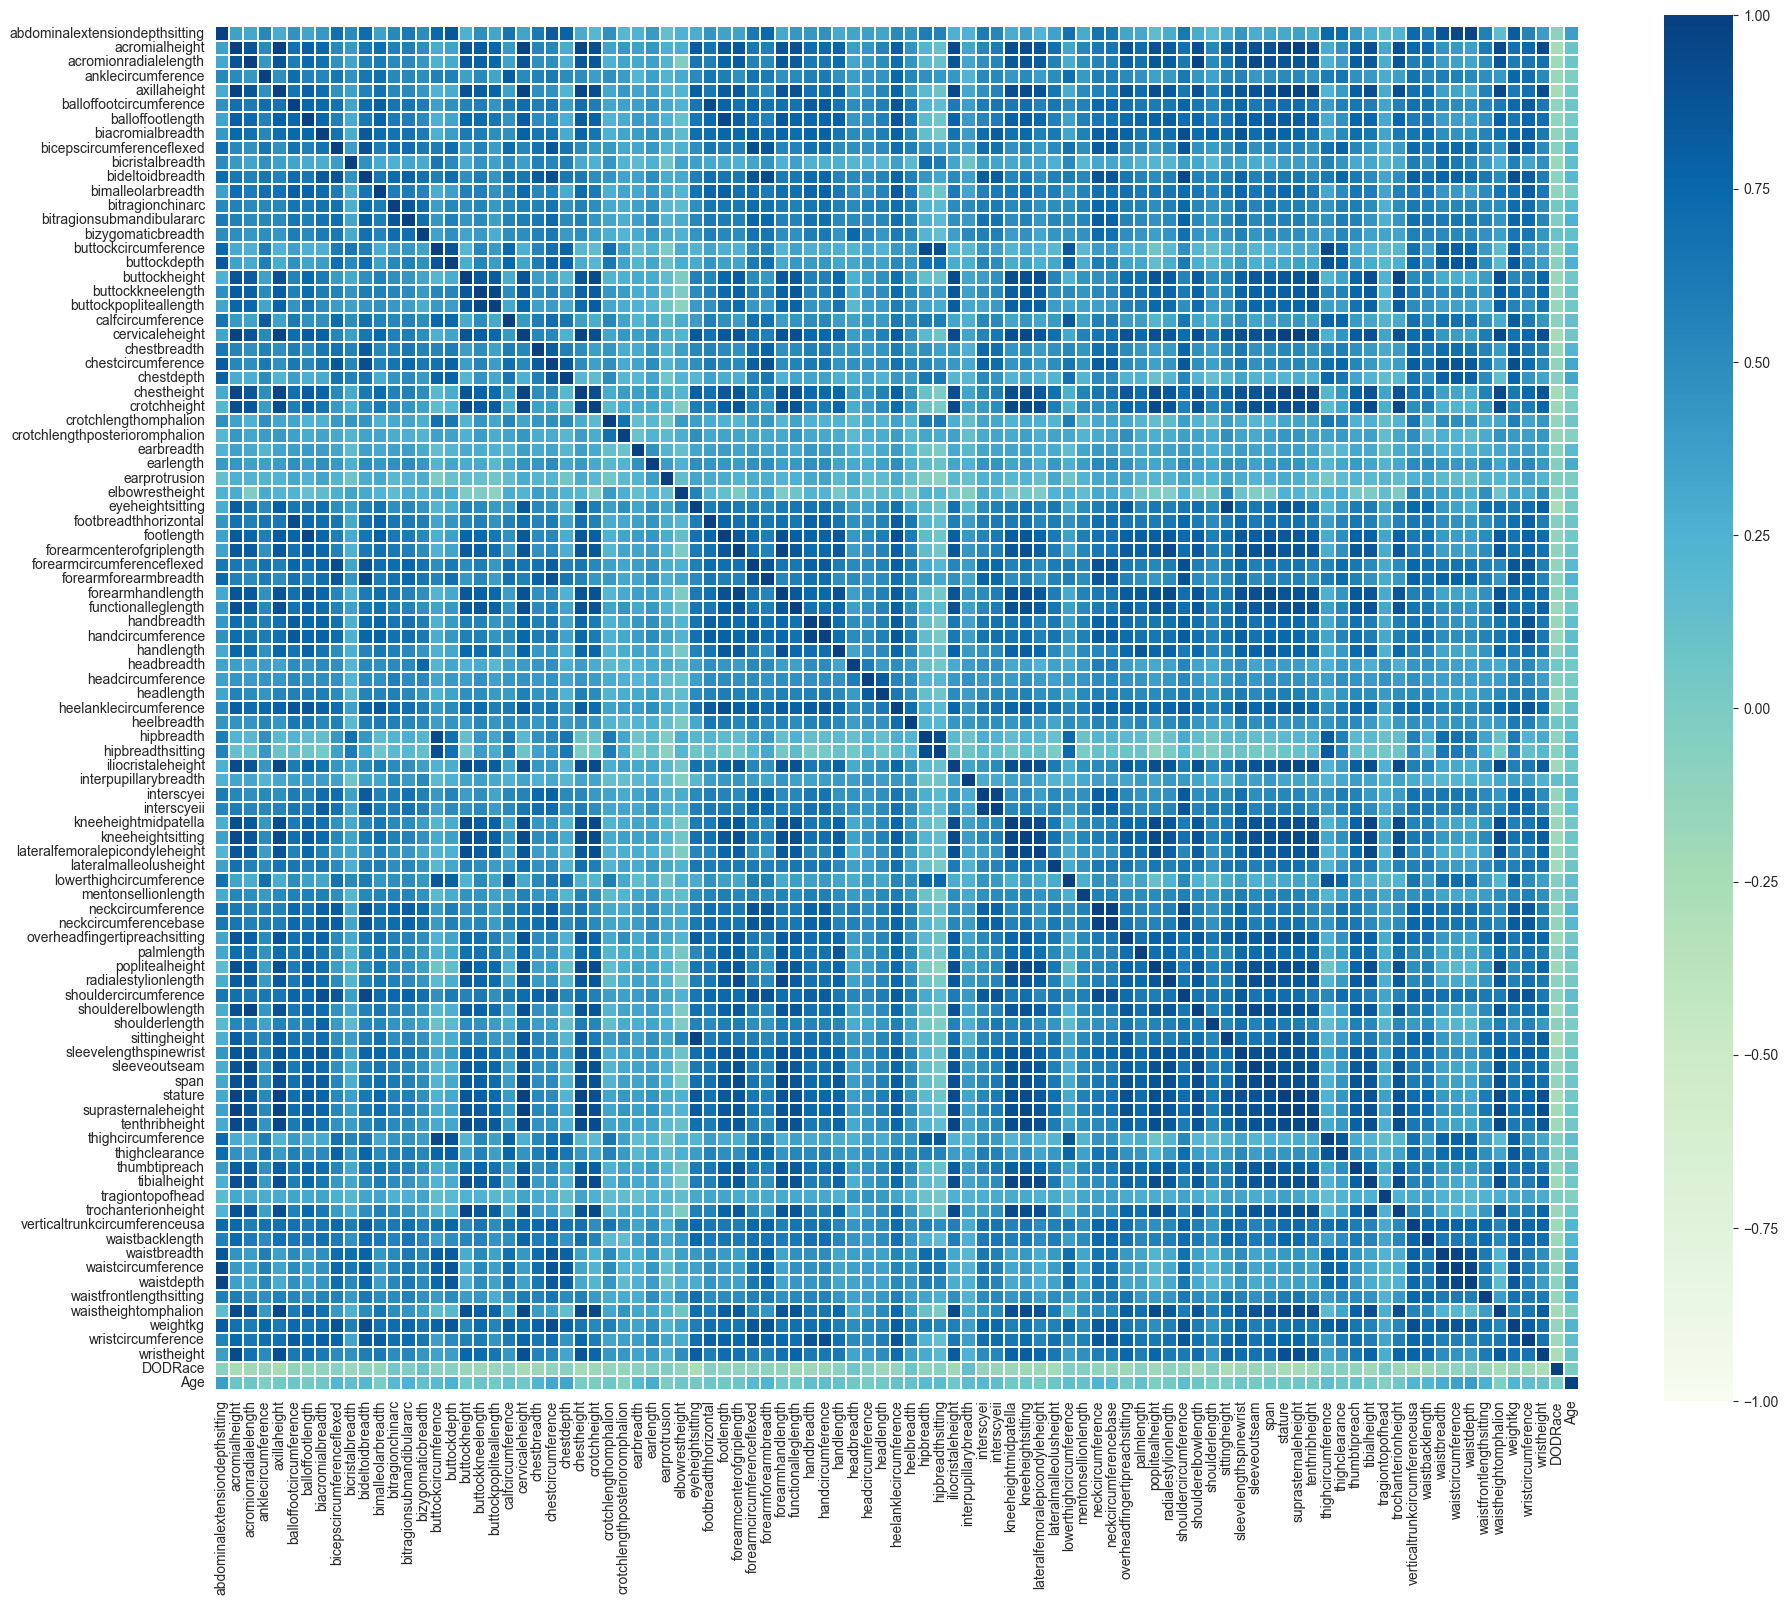

In [35]:
plt.figure(figsize=(22, 18))
sns.heatmap(df.corr(numeric_only=True), 
            vmin=-1,
            vmax= 1,
            cmap= 'GnBu', 
            linewidths=.12, 
            linecolor='white',
            fmt='.2g',
            square=True);

It's hard to visualuze the correlation since we have too many features

In [36]:
# show correlated features with 0.9 correlation scores
correlations = df.corr(numeric_only=True).unstack().sort_values()
highest_corr = correlations[correlations > 0.9]
highest_corr

chestheight                     kneeheightmidpatella              0.900121
kneeheightmidpatella            chestheight                       0.900121
hipbreadthsitting               buttockcircumference              0.900228
buttockcircumference            hipbreadthsitting                 0.900228
poplitealheight                 stature                           0.900976
stature                         poplitealheight                   0.900976
shouldercircumference           biacromialbreadth                 0.901051
biacromialbreadth               shouldercircumference             0.901051
poplitealheight                 suprasternaleheight               0.901304
suprasternaleheight             poplitealheight                   0.901304
poplitealheight                 tenthribheight                    0.901478
tenthribheight                  poplitealheight                   0.901478
wristcircumference              handcircumference                 0.901539
handcircumference        

In [37]:
pprint(mapping('DODRace'))

['Department of Defense Race; a single digit indicating a subject’s '
 'self-reported preferred single race where selecting multiple races is not an '
 'option. This variable is intended to be comparable to the Defense Manpower '
 'Data Center demographic data. Where 1 = White, 2 = Black, 3 = Hispanic, 4 = '
 'Asian, 5 = Native American, 6 = Pacific Islander, 8 = Other']


In [38]:
df['DODRace'] = df['DODRace'].map({
1:'White', 2:'Black', 3:'Hispanic',
4:'Asian', 5:'Native American', 
6:'Pacific Islander', 8:'Other'})

In [39]:
value_counts = df['DODRace'].value_counts()

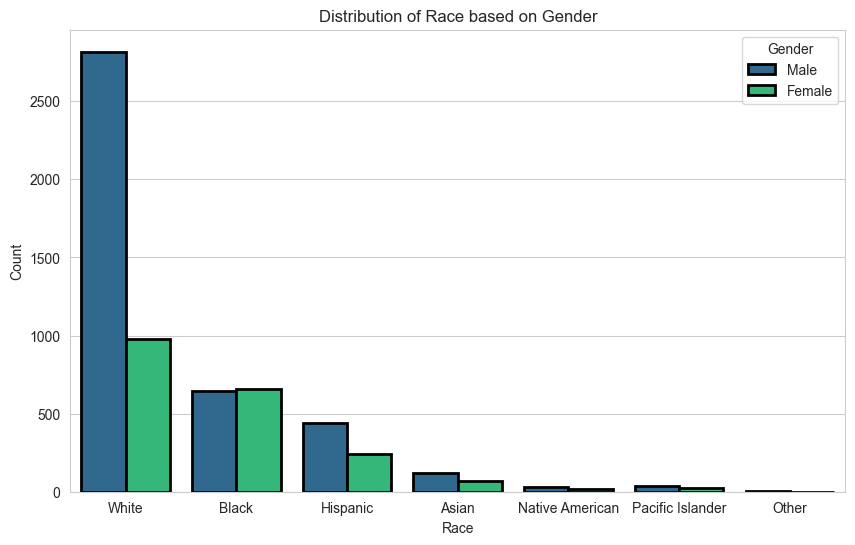

In [40]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='DODRace', hue='Gender', saturation=1, edgecolor='k',
              linewidth=2, palette='viridis')
plt.title(f'Distribution of Race based on Gender')
plt.xlabel('Race')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.show()

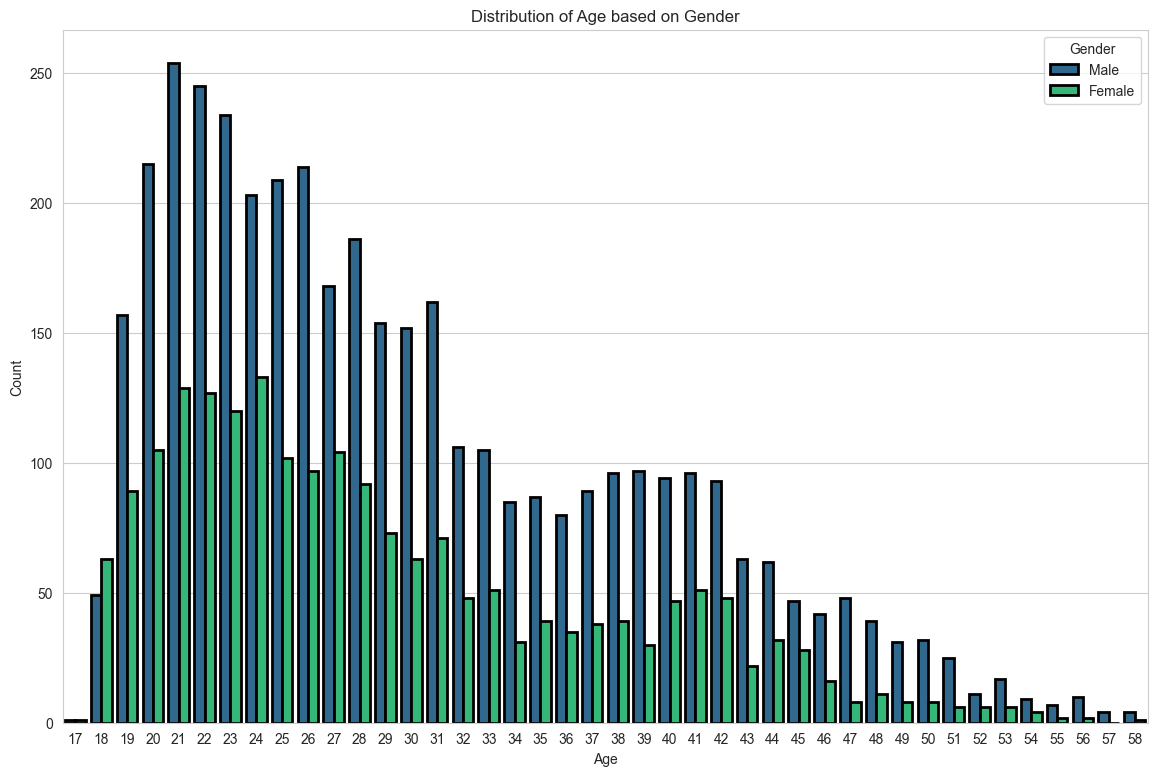

In [42]:
plt.figure(figsize=(14, 9))
sns.countplot(data=df, x='Age', hue='Gender', saturation=1, edgecolor='k',
              linewidth=2, palette='viridis')
plt.title(f'Distribution of Age based on Gender')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.show()

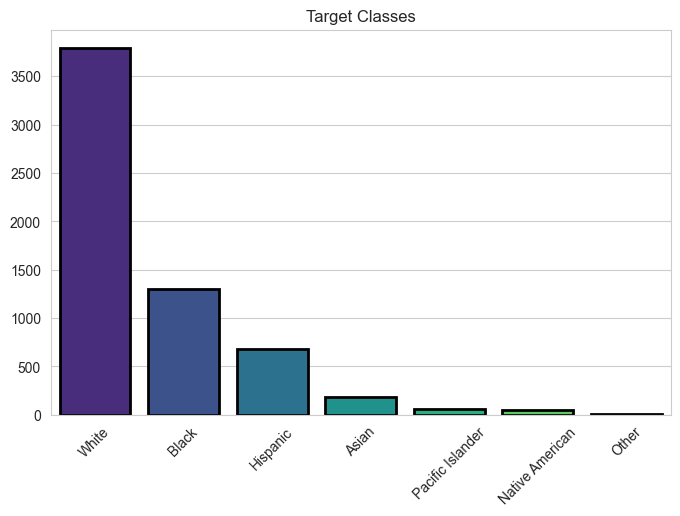

In [43]:
# visualizing our target distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=value_counts.index, y=value_counts.values,
            saturation=1, edgecolor='k',
            linewidth=2, palette='viridis')
plt.xticks(rotation=45)
plt.title(f'Target Classes')
plt.show()

We're going to predict classes with count higher than 500

In [44]:
value_counts = df['DODRace'].value_counts()

# classes with count of 500 or more
race_classes = list(value_counts[value_counts >= 500].index)
race_classes

['White', 'Black', 'Hispanic']

In [45]:
# keep rows that has one of the 3 classes
df = df[df['DODRace'].isin(race_classes)]
df.shape

(5769, 98)

## Outliers handling

In [46]:
df.reset_index(drop=True, inplace=True)

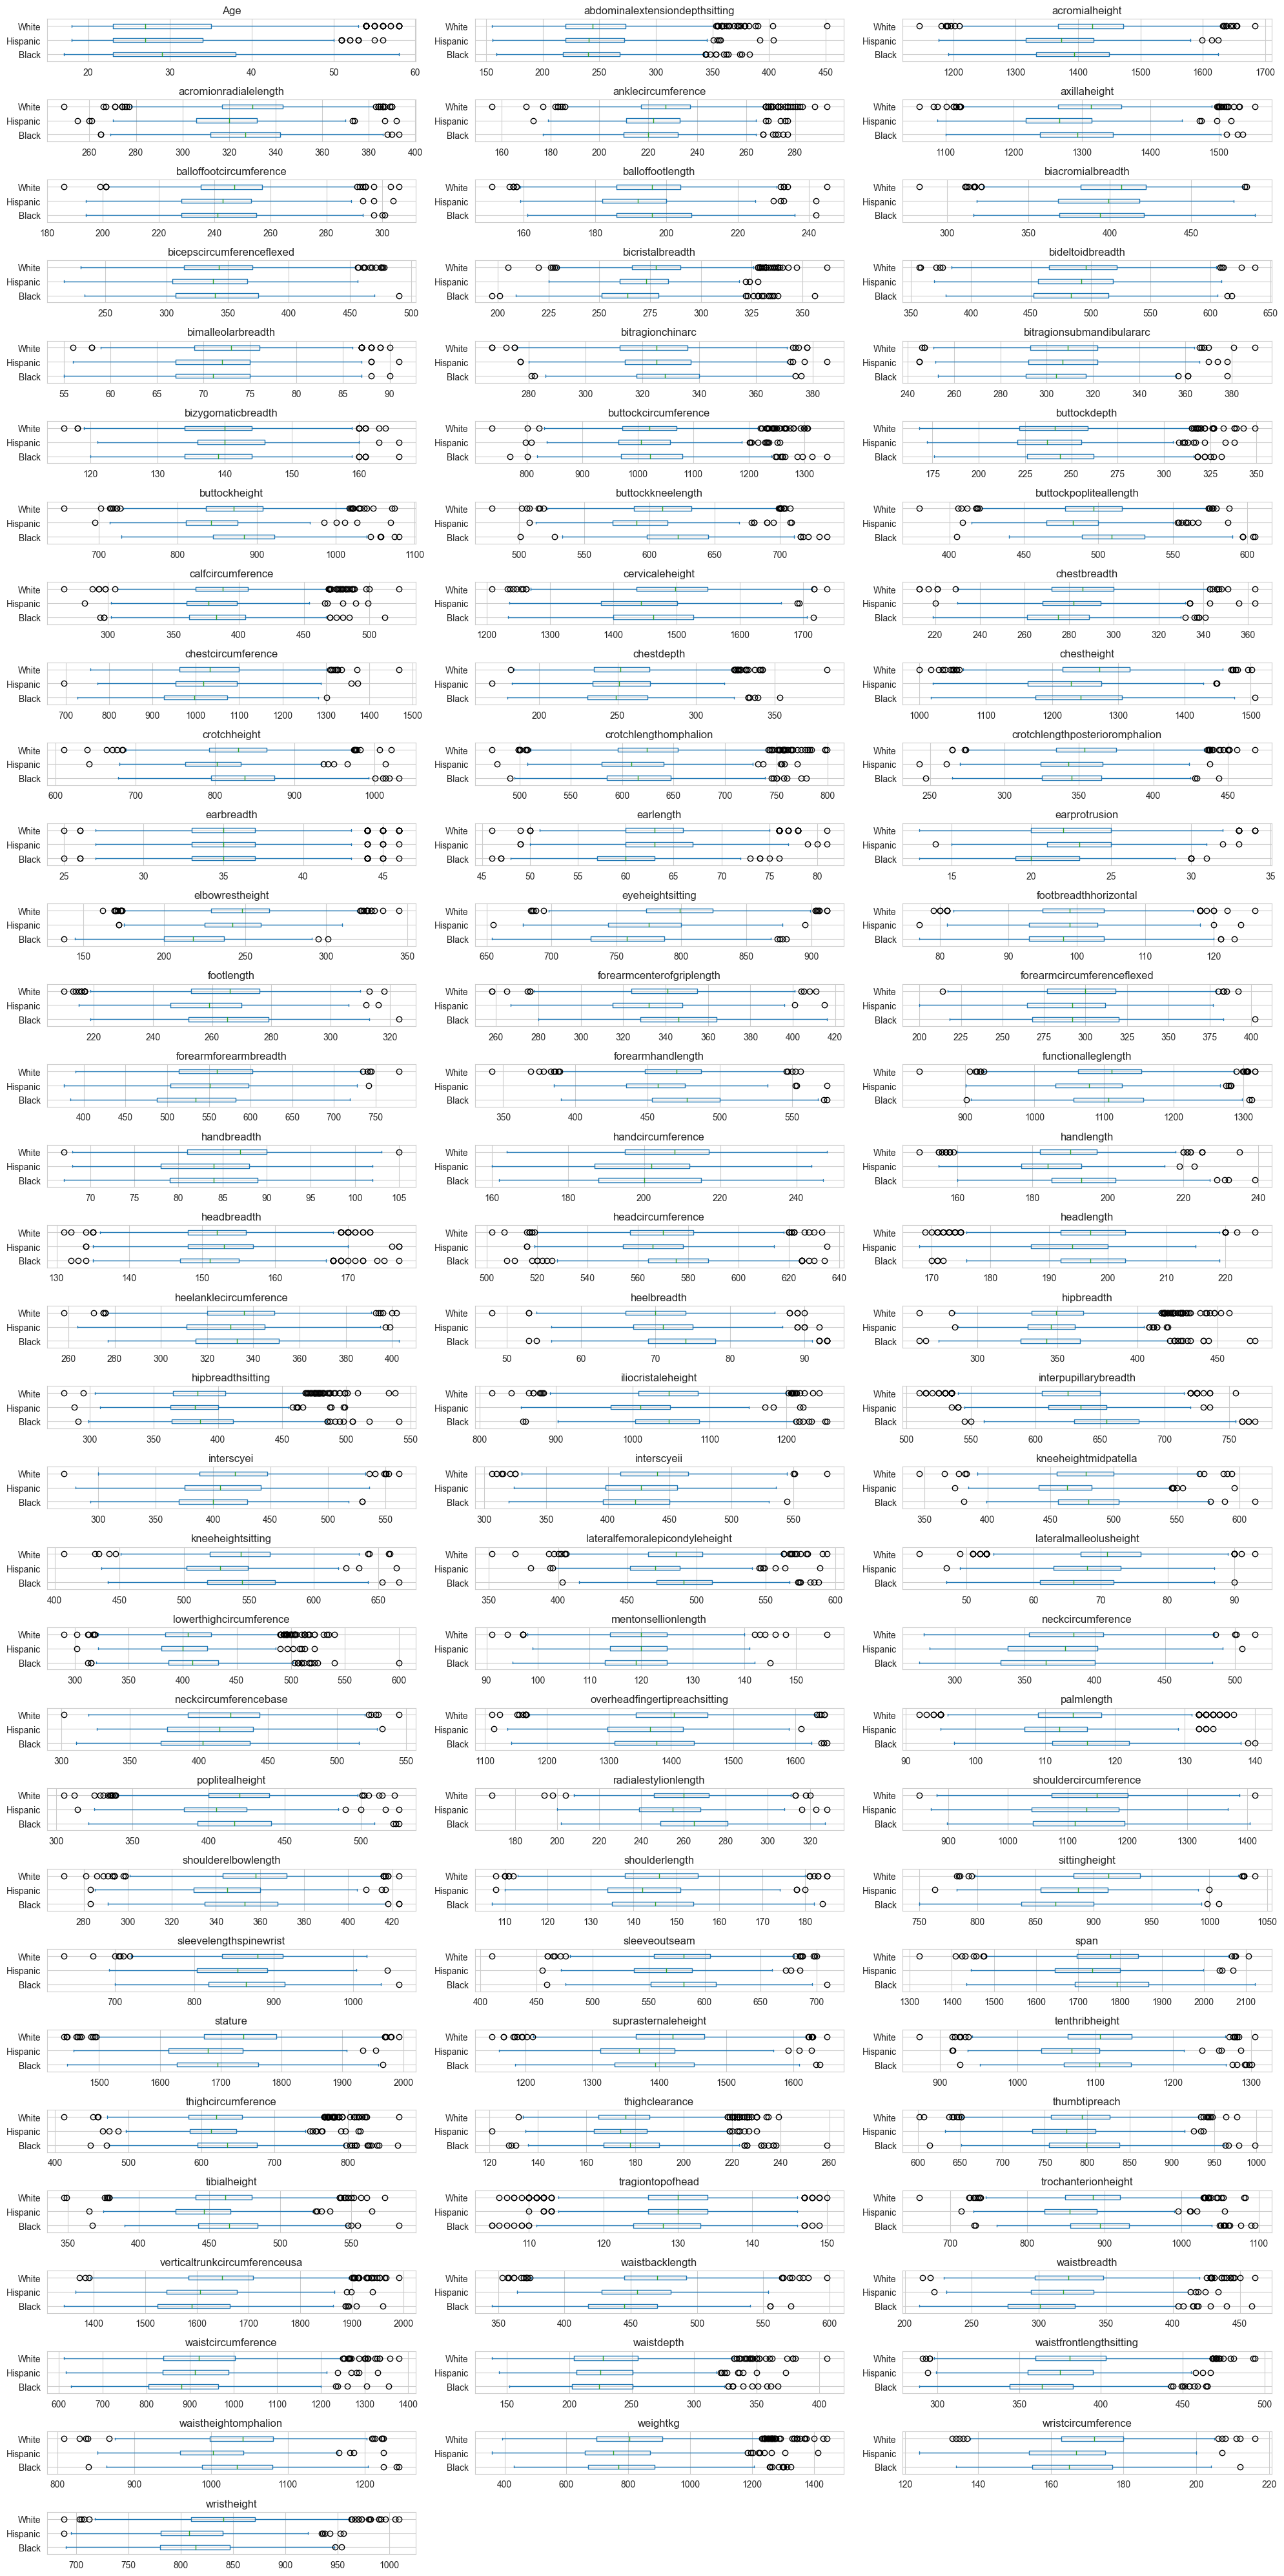

In [47]:
df.plot(by='DODRace', kind='box', subplots=True, layout=(32, 3),
        figsize=(20, 40), vert=False, sharex=False, sharey=False)
plt.tight_layout()

The effect of outliers is not huge, so we will not drop them 
* using MinMax scaler to handle outliers

### Data harmonization
must check for consistent units of Measurement

In [48]:
mapping('NOTE')

['measurements are recorded in millimeters with the exception of the variable “weightkg”.']

In [49]:
subset = df.describe().T
subset = subset[['std', 'mean', 'max', 'min']]
subset

std         mean     max     min
abdominalextensiondepthsitting   37.457748   247.254290   451.0   155.0
acromialheight                   78.303123  1408.630265  1683.0  1146.0
acromionradialelength            20.444554   328.071590   393.0   249.0
anklecircumference               15.965783   225.201768   293.0   156.0
axillaheight                     71.260913  1301.902583  1553.0  1062.0
balloffootcircumference          16.803556   244.408043   306.0   186.0
balloffootlength                 13.379000   195.118911   245.0   151.0
biacromialbreadth                30.124094   399.706015   489.0   283.0
bicepscircumferenceflexed        41.270615   341.663027   490.0   216.0
bicristalbreadth                 19.239580   274.903449   362.0   197.0
bideltoidbreadth                 42.011888   491.454845   637.0   357.0
bimalleolarbreadth                5.326965    72.335413    91.0    55.0
bitragionchinarc                 17.050426   324.962212   385.0   267.0
bitragionsubmandibulararc        20.818789   306.677760   390.0   245.0
bizygomaticbreadth                7.248670   139.529381   166.0   116.0
buttockcircumference             75.952953  1022.059456  1341.0   737.0
buttockdepth                     26.409001   242.234356   349.0   168.0
buttockheight                    54.064846   872.112845  1080.0   656.0
buttockkneelength                33.120828   610.449991   736.0   479.0
buttockpopliteallength           28.512562   498.331773   605.0   380.0
calfcircumference                30.577787   386.316519   523.0   266.0
cervicaleheight                  83.590746  1479.952158  1738.0  1208.0
chestbreadth                     20.612214   283.232623   363.0   213.0
chestcircumference              100.375776  1024.206622  1469.0   695.0
chestdepth                       26.660255   252.322586   383.0   170.0
chestheight                      78.882449  1254.290172  1506.0  1000.0
crotchheight                     54.056267   827.105738  1031.0   610.0
crotchlengthomphalion            45.087220   622.693708   799.0   473.0
crotchlengthposterioromphalion   29.807293   351.880222   468.0   243.0
earbreadth                        3.221118    35.175420    46.0    25.0
earlength                         4.861629    62.606171    81.0    46.0
earprotrusion                     3.149012    22.227249    34.0    13.0
elbowrestheight                  28.595503   240.553302   345.0   138.0
eyeheightsitting                 41.843182   786.399203   912.0   654.0
footbreadthhorizontal             6.658949    98.915063   126.0    77.0
footlength                       17.231642   263.512394   323.0   210.0
forearmcenterofgriplength        23.081597   339.458832   416.0   258.0
forearmcircumferenceflexed       29.857253   295.661640   402.0   200.0
forearmforearmbreadth            62.255490   553.098284   778.0   376.0
forearmhandlength                29.785714   467.898769   574.0   342.0
functionalleglength              67.719289  1104.347201  1316.0   835.0
handbreadth                       6.320915    85.098111   105.0    67.0
handcircumference                15.486056   204.215635   248.0   160.0
handlength                       11.422521   189.574796   239.0   150.0
headbreadth                       6.176650   152.043682   177.0   131.0
headcircumference                18.245395   570.424337   635.0   502.0
headlength                        8.322907   196.640839   225.0   168.0
heelanklecircumference           22.260663   333.274918   403.0   258.0
heelbreadth                       5.932530    70.834113    93.0    48.0
hipbreadth                       25.191381   348.930837   473.0   264.0
hipbreadthsitting                32.273943   386.417923   541.0   280.0
iliocristaleheight               59.102058  1042.152366  1253.0   816.0
interpupillarybreadth            36.644621   632.534928   770.0   510.0
interscyei                       42.868488   412.773964   562.0   270.0
interscyeii                      38.513152   433.017334   577.0   306.0
kneehei

all the data are in correct units

# DATA Preprocessing


### Data Splitting

In [50]:
# splitting X and y
X = df.drop(columns = ['DODRace'])
y = df['DODRace']

In [51]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=2023)

In [52]:
X_train.shape

(4615, 97)

In [53]:
X_test.shape

(1154, 97)

### Column Transformer

In [54]:
cat_columns = list(df.select_dtypes(include=['object']).columns)
cat_columns.remove('DODRace')

In [55]:
cat_columns

['Gender', 'SubjectsBirthLocation', 'WritingPreference']

In [56]:
column_trans = make_column_transformer((
               OneHotEncoder( handle_unknown='ignore',
                              sparse_output=False), 
                              cat_columns),
                              remainder = 'passthrough', 
                              verbose_feature_names_out=False).set_output(transform="pandas")

In [57]:
# our scaller 
sc = MinMaxScaler()

# Modelling
We are going to try 4 algorithms
- Logistic Regression
- SVM
- Random Forest
- XGBoost

### Evaluation metric

In [58]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    '''
    Description:
    This function gets a model, train and test sets and return 
    the confusion matrix and classification report
    
    INPUT:
    model - fitted model
    X_train - input features for the training set
    y_train - target values for training set
    X_test - input features for the testing set
    y_test - target values for testing set
    
    RETURN:
    Nothing

    '''
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)

    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))
    print()
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

### Scorrer for Hispanic Class

Hispanic class performed way worse during the early experiments, so our focus will be to increase the recall scores for this class 

In [59]:
f1_hespanic = make_scorer(f1_score, average=None, labels=['Hispanic'])

precision_hespanic = make_scorer(precision_score, average=None, labels=['Hispanic'])

recall_hespanic = make_scorer(recall_score, average=None, labels=['Hispanic'])


scoring = {'f1_hespanic': f1_hespanic,
           'precision_hespanic': precision_hespanic, 
           'recall_hespanic': recall_hespanic}

## 1. Logistic model

### Vanilla Logistic Model

In [60]:
# Linear regression model
lr = LogisticRegression(max_iter=1000, random_state=2023)
# setting max iteration to 1000 for multiclass to make sure solvers have enough iterations to converge
lr_pipe = make_pipeline(column_trans, sc, lr)

lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender',
                                                   'SubjectsBirthLocation',
                                                   'WritingPreference'])],
                                   verbose_feature_names_out=False)),
                ('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=2023))])

In [61]:
eval_metric(lr_pipe, X_train, y_train, X_test, y_test)

Train_Set
[[ 936   25   77]
 [  34  316  193]
 [  25   58 2951]]
              precision    recall  f1-score   support

       Black       0.94      0.90      0.92      1038
    Hispanic       0.79      0.58      0.67       543
       White       0.92      0.97      0.94      3034

    accuracy                           0.91      4615
   macro avg       0.88      0.82      0.85      4615
weighted avg       0.91      0.91      0.91      4615


Test_Set
[[232   6  22]
 [ 10  70  56]
 [  8  15 735]]
              precision    recall  f1-score   support

       Black       0.93      0.89      0.91       260
    Hispanic       0.77      0.51      0.62       136
       White       0.90      0.97      0.94       758

    accuracy                           0.90      1154
   macro avg       0.87      0.79      0.82      1154
weighted avg       0.89      0.90      0.89      1154



In [62]:
scores = cross_validate(lr_pipe,
                        X_train,
                        y_train,
                        scoring=scoring,
                        cv = 10,
                        n_jobs=-1,
                        return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_f1_hespanic            0.636796
train_f1_hespanic           0.667919
test_precision_hespanic     0.771252
train_precision_hespanic    0.792435
test_recall_hespanic        0.548990
train_recall_hespanic       0.577244
dtype: float64

### Logistic Model GridsearchCV

In [63]:
lr_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    ['Gender', 'SubjectsBirthLocation',
                                     'WritingPreference'])],
                     verbose_feature_names_out=False)),
  ('minmaxscaler', MinMaxScaler()),
  ('logisticregression',
   LogisticRegression(max_iter=1000, random_state=2023))],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse_output=False),
                                  ['Gender', 'SubjectsBirthLocation',
                                   'WritingPref

In [94]:
lr_param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1],
              'logisticregression__class_weight': ['balanced', {'White':1,'Hispanic':3.5,'Black':2}, 
              {'White':1,'Hispanic':4,'Black':2.5}, {'White':1,'Hispanic':4.5,'Black':2}],
              'logisticregression__penalty': ['l1', 'l2'],
              # from docs : For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;
              'logisticregression__solver': ['liblinear','sag','saga','newton-cg'],
              }

Warning

The choice of the algorithm depends on the penalty chosen. Supported penalties by solver:

- ‘lbfgs’ - [‘l2’, None]

- ‘liblinear’ - [‘l1’, ‘l2’]

- ‘newton-cg’ - [‘l2’, None]

- ‘newton-cholesky’ - [‘l2’, None]

- ‘sag’ - [‘l2’, None]

- ‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, None]



The grid search will ignore incorrect combinations 

In [95]:
lr_model_grid = GridSearchCV(lr_pipe,
                              lr_param_grid ,
                              scoring=recall_hespanic,
                              cv=10,
                              n_jobs=-1,
                              return_train_score=True)
lr_model_grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Gender',
                                                                          'SubjectsBirthLocation',
                                                                          'WritingPreference'])],
                                                          verbose_feature_names_out=False)),
                                       ('minmaxscaler', MinMaxScaler()),
                                       ('logisticregression',
                                        Logisti...
                         'logisticregression__class_weight': ['balanced',
                                                              {'Black': 2,
                                                               'Hispanic': 3.5,
                                                               'White': 1},
                                                              {'Black': 2.5,
                                                               'Hispanic': 4,
                                                               'White': 1},
                                                              {'Black': 2,
                                                               'Hispanic': 4.5,
                                                               'White': 1}],
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['liblinear', 'sag',
                                                        'saga', 'newton-cg']},
             return_train_score=True,
             scoring=make_scorer(recall_score, average=None, labels=['Hispanic']))

In [96]:
lr_model_grid.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender',
                                                   'SubjectsBirthLocation',
                                                   'WritingPreference'])],
                                   verbose_feature_names_out=False)),
                ('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                                    random_state=2023, solver='sag'))])

In [97]:
eval_metric(lr_model_grid, X_train, y_train, X_test, y_test)

Train_Set
[[ 949   47   42]
 [  28  440   75]
 [  62  360 2612]]
              precision    recall  f1-score   support

       Black       0.91      0.91      0.91      1038
    Hispanic       0.52      0.81      0.63       543
       White       0.96      0.86      0.91      3034

    accuracy                           0.87      4615
   macro avg       0.80      0.86      0.82      4615
weighted avg       0.90      0.87      0.88      4615


Test_Set
[[238  17   5]
 [  6 109  21]
 [ 19  84 655]]
              precision    recall  f1-score   support

       Black       0.90      0.92      0.91       260
    Hispanic       0.52      0.80      0.63       136
       White       0.96      0.86      0.91       758

    accuracy                           0.87      1154
   macro avg       0.80      0.86      0.82      1154
weighted avg       0.90      0.87      0.88      1154



In [99]:
pd.DataFrame(lr_model_grid.cv_results_).loc[
    lr_model_grid.best_index_, ["mean_test_score", "mean_train_score"]
]

mean_test_score     0.768047
mean_train_score     0.81461
Name: 101, dtype: object

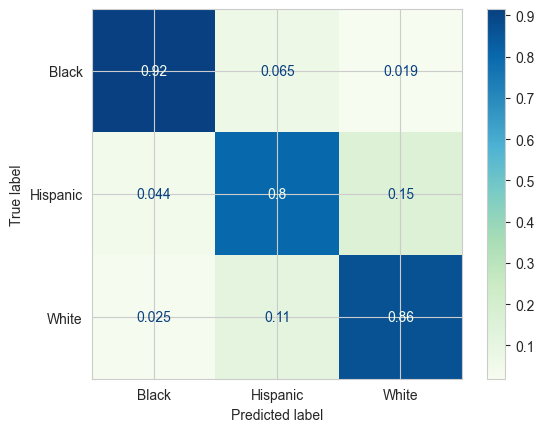

In [100]:
# normalize the matrix to show percentage of correctly classified samples
ConfusionMatrixDisplay.from_estimator(lr_model_grid,X_test, y_test,normalize='true', cmap='GnBu');

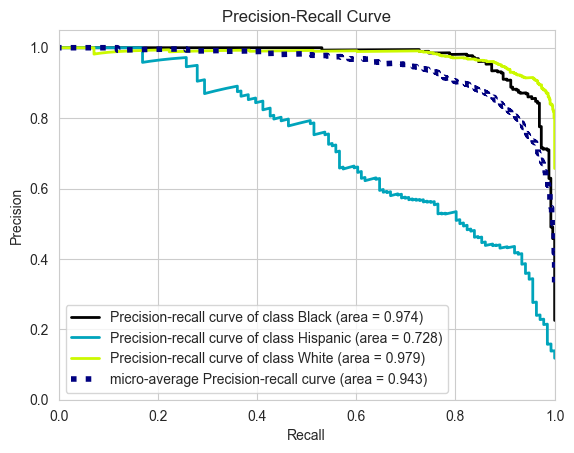

In [101]:
# getting classes probs from the tuned model

y_pred_proba = lr_model_grid.predict_proba(X_test)

plot_precision_recall(y_test, y_pred_proba)
plt.show();

## 2. SVC

### Vanilla SVC model 

In [102]:
# SVM model
svm = SVC(random_state=2023)

svm_pipe = make_pipeline(column_trans, sc, svm)

svm_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender',
                                                   'SubjectsBirthLocation',
                                                   'WritingPreference'])],
                                   verbose_feature_names_out=False)),
                ('minmaxscaler', MinMaxScaler()),
                ('svc', SVC(random_state=2023))])

In [103]:
eval_metric(svm_pipe, X_train, y_train, X_test, y_test)

Train_Set
[[ 924   12  102]
 [  37  213  293]
 [  15   20 2999]]
              precision    recall  f1-score   support

       Black       0.95      0.89      0.92      1038
    Hispanic       0.87      0.39      0.54       543
       White       0.88      0.99      0.93      3034

    accuracy                           0.90      4615
   macro avg       0.90      0.76      0.80      4615
weighted avg       0.90      0.90      0.88      4615


Test_Set
[[224   2  34]
 [ 12  50  74]
 [  6   4 748]]
              precision    recall  f1-score   support

       Black       0.93      0.86      0.89       260
    Hispanic       0.89      0.37      0.52       136
       White       0.87      0.99      0.93       758

    accuracy                           0.89      1154
   macro avg       0.90      0.74      0.78      1154
weighted avg       0.89      0.89      0.87      1154



###  SVC Model GridsearchCV

In [104]:
svm_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    ['Gender', 'SubjectsBirthLocation',
                                     'WritingPreference'])],
                     verbose_feature_names_out=False)),
  ('minmaxscaler', MinMaxScaler()),
  ('svc', SVC(random_state=2023))],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse_output=False),
                                  ['Gender', 'SubjectsBirthLocation',
                                   'WritingPreference'])],
                   verbose_feature_n

In [105]:
svm_param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'poly', 'rbf'],
    'svc__degree': [2, 3, 4],
    'svc__class_weight': ['balanced'] #not testing other weights to reduce compt time
}

In [106]:
svm_model_grid = GridSearchCV(svm_pipe,
                              svm_param_grid ,
                              scoring=recall_hespanic,
                              cv=10,
                              n_jobs=-1,
                              return_train_score=True)
svm_model_grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Gender',
                                                                          'SubjectsBirthLocation',
                                                                          'WritingPreference'])],
                                                          verbose_feature_names_out=False)),
                                       ('minmaxscaler', MinMaxScaler()),
                                       ('svc', SVC(random_state=2023))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1, 10],
                         'svc__class_weight': ['balanced'],
                         'svc__degree': [2, 3, 4],
                         'svc__kernel': ['linear', 'poly', 'rbf']},
             return_train_score=True,
             scoring=make_scorer(recall_score, average=None, labels=['Hispanic']))

In [107]:
svm_model_grid.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender',
                                                   'SubjectsBirthLocation',
                                                   'WritingPreference'])],
                                   verbose_feature_names_out=False)),
                ('minmaxscaler', MinMaxScaler()),
                ('svc',
                 SVC(C=0.1, class_weight='balanced', degree=4, kernel='poly',
                     random_state=2023))])

In [108]:
eval_metric(svm_model_grid, X_train, y_train, X_test, y_test)

Train_Set
[[ 937   69   32]
 [  19  467   57]
 [  55  449 2530]]
              precision    recall  f1-score   support

       Black       0.93      0.90      0.91      1038
    Hispanic       0.47      0.86      0.61       543
       White       0.97      0.83      0.90      3034

    accuracy                           0.85      4615
   macro avg       0.79      0.87      0.81      4615
weighted avg       0.90      0.85      0.87      4615


Test_Set
[[225  24  11]
 [  3 111  22]
 [ 23 104 631]]
              precision    recall  f1-score   support

       Black       0.90      0.87      0.88       260
    Hispanic       0.46      0.82      0.59       136
       White       0.95      0.83      0.89       758

    accuracy                           0.84      1154
   macro avg       0.77      0.84      0.79      1154
weighted avg       0.88      0.84      0.85      1154



In [109]:
pd.DataFrame(svm_model_grid.cv_results_).loc[
    svm_model_grid.best_index_, ["mean_test_score", "mean_train_score"]
]

mean_test_score      0.80303
mean_train_score    0.865971
Name: 7, dtype: object

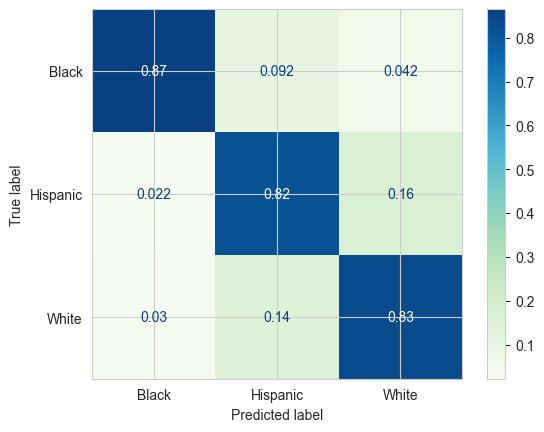

In [110]:
ConfusionMatrixDisplay.from_estimator(svm_model_grid,X_test, y_test,normalize='true', cmap='GnBu');

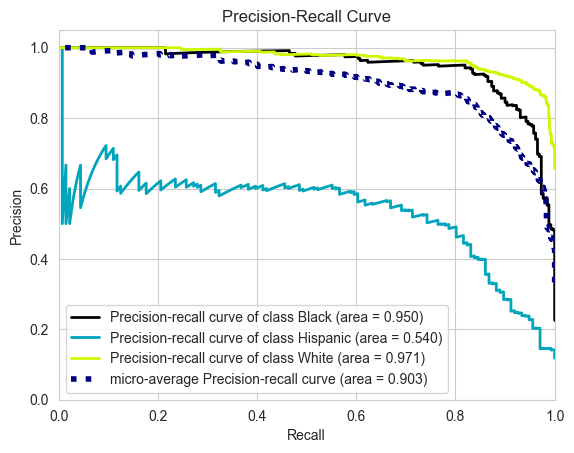

In [112]:
# getting classes probs from the tuned model
y_pred_proba = svm_model_grid.decision_function(X_test)

plot_precision_recall(y_test, y_pred_proba)
plt.show();

although the results on test are high the class has very weak precision scores

In [113]:
# testing with f1 score
svm_model_grid2 = GridSearchCV(svm_pipe,
                              svm_param_grid ,
                              scoring=f1_hespanic,
                              cv=10,
                              n_jobs=-1,
                              return_train_score=True)
svm_model_grid2.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Gender',
                                                                          'SubjectsBirthLocation',
                                                                          'WritingPreference'])],
                                                          verbose_feature_names_out=False)),
                                       ('minmaxscaler', MinMaxScaler()),
                                       ('svc', SVC(random_state=2023))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1, 10],
                         'svc__class_weight': ['balanced'],
                         'svc__degree': [2, 3, 4],
                         'svc__kernel': ['linear', 'poly', 'rbf']},
             return_train_score=True,
             scoring=make_scorer(f1_score, average=None, labels=['Hispanic']))

In [114]:
pd.DataFrame(svm_model_grid2.cv_results_).loc[
    svm_model_grid2.best_index_, ["mean_test_score", "mean_train_score"]
]

mean_test_score     0.600533
mean_train_score    0.783431
Name: 20, dtype: object

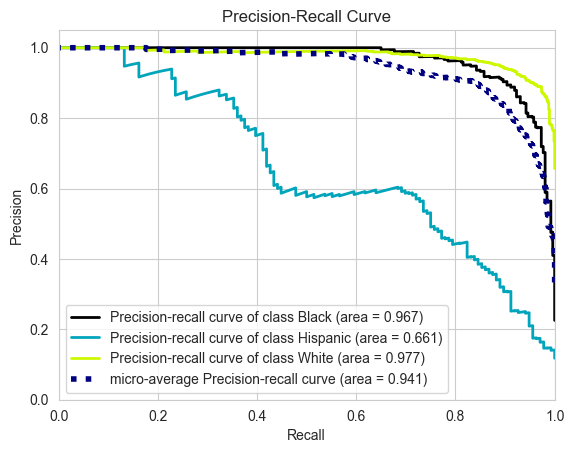

In [115]:
y_pred_proba = svm_model_grid2.decision_function(X_test)

plot_precision_recall(y_test, y_pred_proba)
plt.show();

better than before but not better than tuned LR model

## 3. RF

### Vanilla RF Model

In [116]:
# tree-based models do not need one-hot encoding
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value',
                         unknown_value=-1)


column_trans2 = make_column_transformer((ord_enc, cat_columns),
                                        remainder='passthrough',
                                        verbose_feature_names_out=False).set_output(transform="pandas")

In [118]:
# Vanilla RF
rf = RandomForestClassifier(random_state=2023)

rf_pipe = make_pipeline(column_trans2, rf) #no need for scaling 

rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Gender',
                                                   'SubjectsBirthLocation',
                                                   'WritingPreference'])],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=2023))])

In [119]:
eval_metric(rf_pipe, X_train, y_train, X_test, y_test)

Train_Set
[[1038    0    0]
 [   0  543    0]
 [   0    0 3034]]
              precision    recall  f1-score   support

       Black       1.00      1.00      1.00      1038
    Hispanic       1.00      1.00      1.00       543
       White       1.00      1.00      1.00      3034

    accuracy                           1.00      4615
   macro avg       1.00      1.00      1.00      4615
weighted avg       1.00      1.00      1.00      4615


Test_Set
[[193   4  63]
 [ 13   9 114]
 [ 13   3 742]]
              precision    recall  f1-score   support

       Black       0.88      0.74      0.81       260
    Hispanic       0.56      0.07      0.12       136
       White       0.81      0.98      0.88       758

    accuracy                           0.82      1154
   macro avg       0.75      0.60      0.60      1154
weighted avg       0.80      0.82      0.78      1154



The model is overfitting the data and the recall for hespanic is zero

### RF Model GridsearchCV

In [120]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('ordinalencoder',
                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                   unknown_value=-1),
                                    ['Gender', 'SubjectsBirthLocation',
                                     'WritingPreference'])],
                     verbose_feature_names_out=False)),
  ('randomforestclassifier', RandomForestClassifier(random_state=2023))],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('ordinalencoder',
                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                 unknown_value=-1),
                                  ['Gender', 'SubjectsBirthLocation',
                                   'WritingPreference'])],
            

In [121]:
rf_param_grid = {
    'randomforestclassifier__class_weight':['balanced', {'White':1,'Hispanic':3.5,'Black':2}, 
              {'White':1,'Hispanic':4,'Black':2.5}, {'White':1,'Hispanic':4.5,'Black':2}],
    'randomforestclassifier__criterion':['gini','entropy','logg_loss'],
    'randomforestclassifier__max_depth':[2,3,4,5]
}

In [122]:
rf_model_grid = GridSearchCV(rf_pipe,
                              rf_param_grid ,
                              scoring=recall_hespanic,
                              cv=10,
                              n_jobs=-1,
                              return_train_score=True)
rf_model_grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['Gender',
                                                                          'SubjectsBirthLocation',
                                                                          'WritingPreference'])],
                                                          verbose_feature_names_out=False)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(ra...
             param_grid={'randomforestclassifier__class_weight': ['balanced',
                                                                  {'Black': 2,
                                                                   'Hispanic': 3.5,
                                                                   'White': 1},
                                                                  {'Black': 2.5,
                                                                   'Hispanic': 4,
                                                                   'White': 1},
                                                                  {'Black': 2,
                                                                   'Hispanic': 4.5,
                                                                   'White': 1}],
                         'randomforestclassifier__criterion': ['gini',
                                                               'entropy',
                                                               'logg_loss'],
                         'randomforestclassifier__max_depth': [2, 3, 4, 5]},
             return_train_score=True,
             scoring=make_scorer(recall_score, average=None, labels=['Hispanic']))

In [123]:
rf_model_grid.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Gender',
                                                   'SubjectsBirthLocation',
                                                   'WritingPreference'])],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=2,
                                        random_state=2023))])

In [124]:
eval_metric(rf_model_grid, X_train, y_train, X_test, y_test)

Train_Set
[[ 749  175  114]
 [  47  346  150]
 [ 235 1128 1671]]
              precision    recall  f1-score   support

       Black       0.73      0.72      0.72      1038
    Hispanic       0.21      0.64      0.32       543
       White       0.86      0.55      0.67      3034

    accuracy                           0.60      4615
   macro avg       0.60      0.64      0.57      4615
weighted avg       0.76      0.60      0.64      4615


Test_Set
[[183  48  29]
 [ 14  92  30]
 [ 72 293 393]]
              precision    recall  f1-score   support

       Black       0.68      0.70      0.69       260
    Hispanic       0.21      0.68      0.32       136
       White       0.87      0.52      0.65       758

    accuracy                           0.58      1154
   macro avg       0.59      0.63      0.55      1154
weighted avg       0.75      0.58      0.62      1154



In [125]:
pd.DataFrame(rf_model_grid.cv_results_).loc[
    rf_model_grid.best_index_, ["mean_test_score", "mean_train_score"]
]

mean_test_score     0.594714
mean_train_score    0.625738
Name: 0, dtype: object

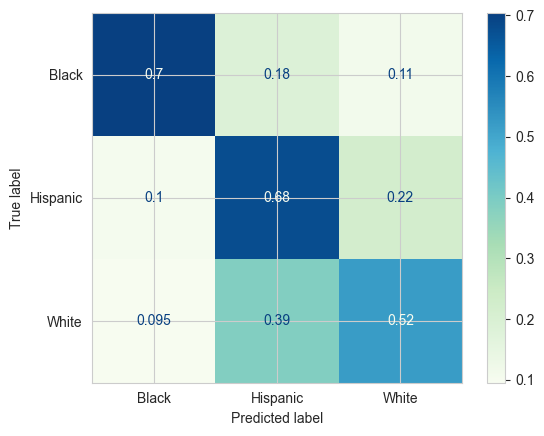

In [126]:
ConfusionMatrixDisplay.from_estimator(rf_model_grid,X_test, y_test,normalize='true', cmap='GnBu');

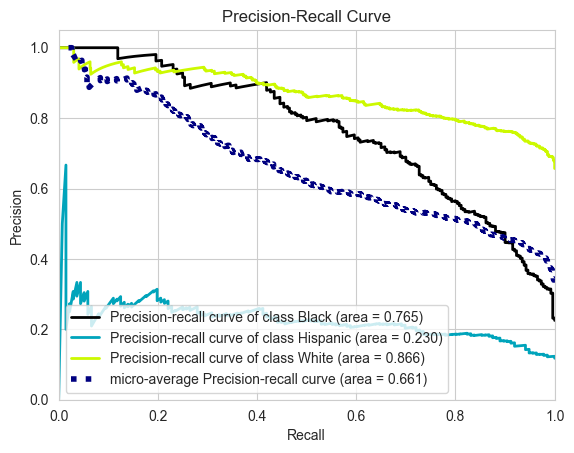

In [127]:
# getting classes probs from the tuned model
y_pred_proba = rf_model_grid.predict_proba(X_test)

plot_precision_recall(y_test, y_pred_proba)
plt.show();

very bad results for hespanic :( 

In [128]:
# testing with f1
rf_model_grid2 = GridSearchCV(rf_pipe,
                              rf_param_grid ,
                              scoring=f1_hespanic,
                              cv=10,
                              n_jobs=-1,
                              return_train_score=True)
rf_model_grid2.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['Gender',
                                                                          'SubjectsBirthLocation',
                                                                          'WritingPreference'])],
                                                          verbose_feature_names_out=False)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(ra...
             param_grid={'randomforestclassifier__class_weight': ['balanced',
                                                                  {'Black': 2,
                                                                   'Hispanic': 3.5,
                                                                   'White': 1},
                                                                  {'Black': 2.5,
                                                                   'Hispanic': 4,
                                                                   'White': 1},
                                                                  {'Black': 2,
                                                                   'Hispanic': 4.5,
                                                                   'White': 1}],
                         'randomforestclassifier__criterion': ['gini',
                                                               'entropy',
                                                               'logg_loss'],
                         'randomforestclassifier__max_depth': [2, 3, 4, 5]},
             return_train_score=True,
             scoring=make_scorer(f1_score, average=None, labels=['Hispanic']))

In [129]:
pd.DataFrame(rf_model_grid2.cv_results_).loc[
    rf_model_grid2.best_index_, ["mean_test_score", "mean_train_score"]
]

mean_test_score     0.361497
mean_train_score    0.484289
Name: 39, dtype: object

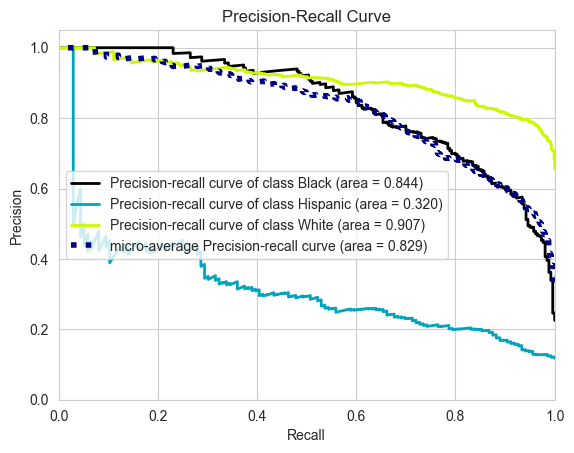

In [130]:
y_pred_proba = rf_model_grid2.predict_proba(X_test)

plot_precision_recall(y_test, y_pred_proba)
plt.show();

Random forest showed the worst results so far

## 4. XGBoost

### Vanilla XGBoost Model

In [152]:
# ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got ['Black' 'Hispanic' 'White']
y_train_encoded = y_train.map({'Black':0, 'Hispanic':1, 'White':2})
y_test_encoded = y_test.map({'Black':0, 'Hispanic':1, 'White':2})

In [169]:
# fixing the labels for scoring
xgb_f1_hespanic = make_scorer(f1_score, average=None, labels=[1])

xgb_precision_hespanic = make_scorer(precision_score, average=None, labels=[1])

xgb_recall_hespanic = make_scorer(recall_score, average=None, labels=[1])


xgb_scoring = {'f1_hespanic': xgb_f1_hespanic,
           'precision_hespanic': xgb_precision_hespanic, 
           'recall_hespanic': xgb_recall_hespanic}

In [153]:
# XGBoost 
xgb =  XGBClassifier(random_state=2023)

# no need for scaler 
# using ordinal transformer
xgb_pipe = make_pipeline(column_trans2, xgb)

xgb_pipe.fit(X_train, y_train_encoded)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Gender',
                                                   'SubjectsBirthLocation',
                                                   'WritingPreference'])],
                                   verbose_feature_names_out=False)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsa...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [154]:
eval_metric(xgb_pipe, X_train, y_train_encoded, X_test, y_test_encoded)

Train_Set
[[1038    0    0]
 [   0  543    0]
 [   0    0 3034]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1038
           1       1.00      1.00      1.00       543
           2       1.00      1.00      1.00      3034

    accuracy                           1.00      4615
   macro avg       1.00      1.00      1.00      4615
weighted avg       1.00      1.00      1.00      4615


Test_Set
[[213  12  35]
 [ 12  51  73]
 [ 14   9 735]]
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       260
           1       0.71      0.38      0.49       136
           2       0.87      0.97      0.92       758

    accuracy                           0.87      1154
   macro avg       0.82      0.72      0.75      1154
weighted avg       0.86      0.87      0.85      1154



### XGBoost Model GridsearchCV

In [134]:
xgb_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('ordinalencoder',
                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                   unknown_value=-1),
                                    ['Gender', 'SubjectsBirthLocation',
                                     'WritingPreference'])],
                     verbose_feature_names_out=False)),
  ('xgbclassifier',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=None, max_bin=None,
                 max_cat_threshold=None, max

In [164]:
xgb_param_grid = {'xgbclassifier__n_estimators': [50,100,150,200],
                  'xgbclassifier__max_depth': [2, 3, 4, 5],
                  }
                  # 'xgbclassifier__scale_pos_weight' is only for binary classification

In [150]:
# computing the balanced weights for each class 
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [151]:
class_weights

array([1.4820167 , 2.8330264 , 0.50703142])

In [148]:
# into dict format
class_weights = {0: 1.4820167, 1: 2.8330264, 2: 0.50703142}

In [159]:
#  list of sample weights based on the labels
sample_weights = [class_weights[label] for label in y_train_encoded]

In [161]:
# passing the weights in pipeline fit caused an issue for me
kwargs = {xgb_pipe.steps[-1][0] + '__sample_weight': sample_weights}
# bug fix found for scikit-learn issues in github [3]

In [162]:
xgb_pipe.fit(X_train, y_train_encoded, **kwargs)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Gender',
                                                   'SubjectsBirthLocation',
                                                   'WritingPreference'])],
                                   verbose_feature_names_out=False)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsa...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

yay it worked :)

In [239]:
xgb_model_grid = GridSearchCV(xgb_pipe,
                             xgb_param_grid,
                             scoring=xgb_recall_hespanic, #update scorer
                             cv=10,
                             n_jobs=-1,
                             return_train_score=True)
xgb_model_grid.fit(X_train, y_train_encoded)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['Gender',
                                                                          'SubjectsBirthLocation',
                                                                          'WritingPreference'])],
                                                          verbose_feature_names_out=False)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      boos...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      objective='multi:softprob',
                                                      predictor=None, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__max_depth': [2, 3, 4, 5],
                         'xgbclassifier__n_estimators': [50, 100, 150, 200]},
             return_train_score=True,
             scoring=make_scorer(recall_score, average=None, labels=[1]))

In [171]:
xgb_model_grid.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Gender',
                                                   'SubjectsBirthLocation',
                                                   'WritingPreference'])],
                                   verbose_feature_names_out=False)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsa...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=150,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [172]:
eval_metric(xgb_model_grid, X_train, y_train_encoded, X_test, y_test_encoded)

Train_Set
[[ 980    7   51]
 [  18  359  166]
 [  10   15 3009]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      1038
           1       0.94      0.66      0.78       543
           2       0.93      0.99      0.96      3034

    accuracy                           0.94      4615
   macro avg       0.95      0.87      0.90      4615
weighted avg       0.94      0.94      0.94      4615


Test_Set
[[222   7  31]
 [ 11  57  68]
 [ 12  12 734]]
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       260
           1       0.75      0.42      0.54       136
           2       0.88      0.97      0.92       758

    accuracy                           0.88      1154
   macro avg       0.85      0.75      0.78      1154
weighted avg       0.87      0.88      0.87      1154



In [168]:
pd.DataFrame(xgb_model_grid.cv_results_).loc[
    xgb_model_grid.best_index_, ["mean_test_score", "mean_train_score"]
]

mean_test_score     0.0
mean_train_score    0.0
Name: 0, dtype: object

we must fix the scorrer to the new labels

In [173]:
# after fixing scorer
pd.DataFrame(xgb_model_grid.cv_results_).loc[
    xgb_model_grid.best_index_, ["mean_test_score", "mean_train_score"]
]

mean_test_score     0.423771
mean_train_score    0.688768
Name: 2, dtype: object

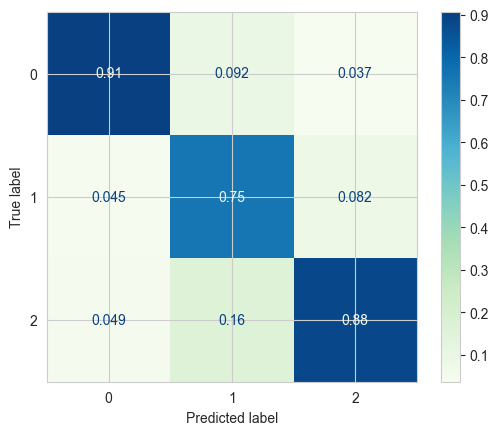

In [178]:
ConfusionMatrixDisplay.from_estimator(xgb_model_grid,X_test, y_test_encoded,normalize='pred', cmap='GnBu');

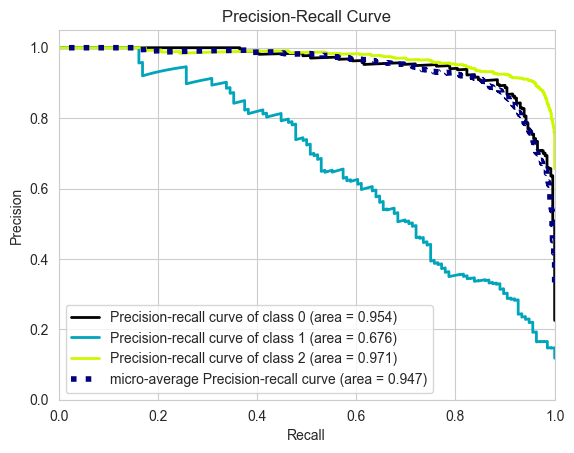

In [179]:
# getting classes probs from the tuned model
y_pred_proba = xgb_model_grid.predict_proba(X_test)

plot_precision_recall(y_test_encoded, y_pred_proba)
plt.show();

trying to improve with f1 score

In [180]:
xgb_model_grid = GridSearchCV(xgb_pipe,
                             xgb_param_grid,
                             scoring=f1_hespanic, 
                             cv=10,
                             n_jobs=-1,
                             return_train_score=True)
xgb_model_grid.fit(X_train, y_train_encoded)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['Gender',
                                                                          'SubjectsBirthLocation',
                                                                          'WritingPreference'])],
                                                          verbose_feature_names_out=False)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      boos...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      objective='multi:softprob',
                                                      predictor=None, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__max_depth': [2, 3, 4, 5],
                         'xgbclassifier__n_estimators': [50, 100, 150, 200]},
             return_train_score=True,
             scoring=make_scorer(f1_score, average=None, labels=['Hispanic']))

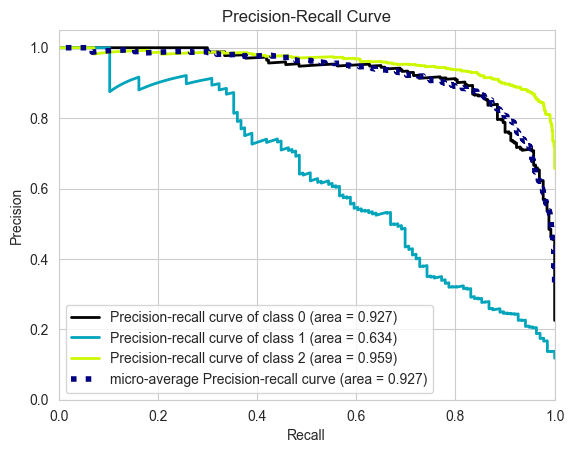

In [181]:
y_pred_proba = xgb_model_grid.predict_proba(X_test)

plot_precision_recall(y_test_encoded, y_pred_proba)
plt.show();

## Performance comparison 

### Vanilla models performance

In [193]:
# passing the trained vanilla models piplines


# logistic regression
lr_scores = cross_validate(lr_pipe,
                        X_train,
                        y_train,
                        scoring=scoring,
                        cv = 10,
                        n_jobs=-1,
                        return_train_score=True)

#support vector machines
svm_scores = cross_validate(svm_pipe,
                        X_train,
                        y_train,
                        scoring=scoring,
                        cv = 10,
                        n_jobs=-1,
                        return_train_score=True)
# random forest                   
rf_scores = cross_validate(rf_pipe,
                        X_train,
                        y_train,
                        scoring=scoring,
                        cv = 10,
                        n_jobs=-1,
                        return_train_score=True)                 
                     
# XGBoost                     
xgb_scores = cross_validate(xgb_pipe,
                        X_train,
                        y_train_encoded,
                        scoring=xgb_scoring,
                        cv = 10,
                        n_jobs=-1,
                        return_train_score=True)  

                     

In [194]:
vanilla_models_score = {
    'Logistic Regression': lr_scores,
    'Support Vector Machines': svm_scores,
    'Random Forest': rf_scores,
    'XGBoost': xgb_scores
}    

In [197]:
vanilla_models_score['Logistic Regression']['test_f1_hespanic'].mean()

0.6367958694442452

storing each scores in a dict

In [198]:
test_f1_hespanic_scores = {}

for model_name, model_scores in vanilla_models_score.items():
    test_f1_hespanic_score = model_scores['test_f1_hespanic'].mean()
    test_f1_hespanic_scores[model_name] = test_f1_hespanic_score

In [205]:
test_recall_hespanic_scores = {}

for model_name, model_scores in vanilla_models_score.items():
    test_recall_hespanic_score = model_scores['test_recall_hespanic'].mean()
    test_recall_hespanic_scores[model_name] = test_recall_hespanic_score

In [207]:
test_precision_hespanic_scores = {}

for model_name, model_scores in vanilla_models_score.items():
    test_precision_hespanic_score = model_scores['test_precision_hespanic'].mean()
    test_precision_hespanic_scores[model_name] = test_precision_hespanic_score

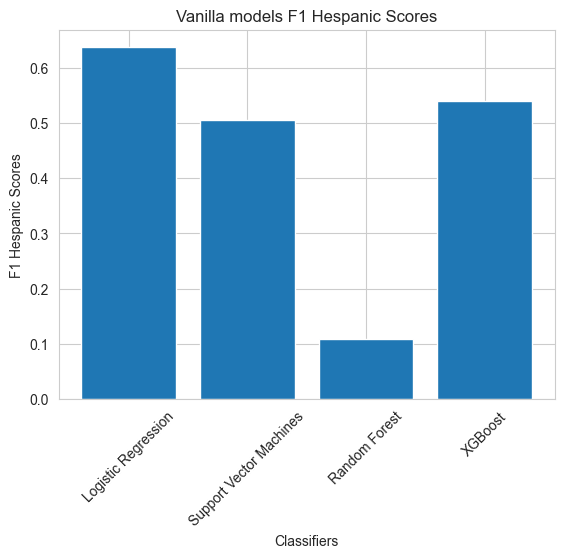

In [244]:
plt.bar(range(len(test_f1_hespanic_scores)), list(test_f1_hespanic_scores.values()), align='center')
plt.xticks(range(len(test_f1_hespanic_scores)), list(test_f1_hespanic_scores.keys()), rotation=45)
plt.xlabel('Classifiers')
plt.ylabel('F1 Hespanic Scores')
plt.title('Vanilla models F1 Hespanic Scores')
plt.show()

The random forest vanilla model showed the worst f1 results compared to other

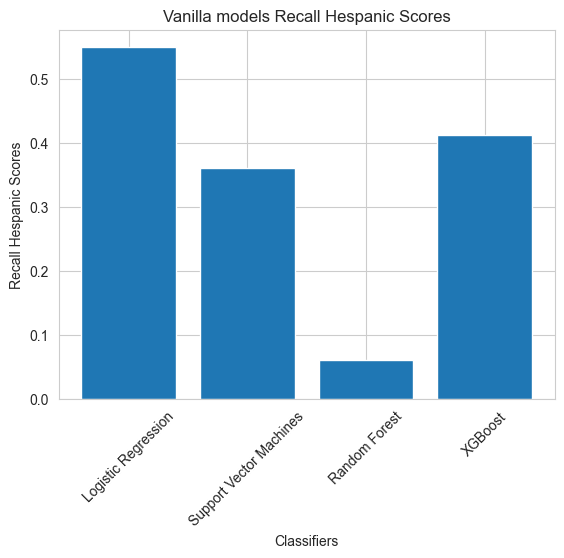

In [211]:
plt.bar(range(len(test_recall_hespanic_scores)), list(test_recall_hespanic_scores.values()), align='center')
plt.xticks(range(len(test_recall_hespanic_scores)), list(test_recall_hespanic_scores.keys()), rotation=45)
plt.xlabel('Classifiers')
plt.ylabel('Recall Hespanic Scores')
plt.title('Vanilla models Recall Hespanic Scores')
plt.show()

The Logistic regression vanilla model showed a good recall score compared to others

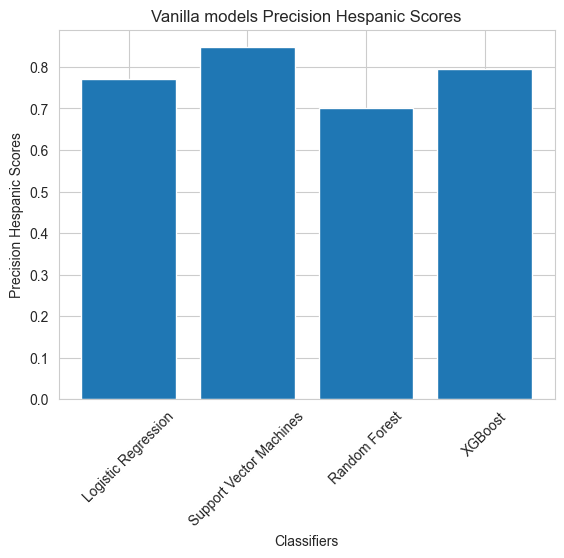

In [212]:
plt.bar(range(len(test_precision_hespanic_scores)), list(test_precision_hespanic_scores.values()), align='center')
plt.xticks(range(len(test_precision_hespanic_scores)), list(test_precision_hespanic_scores.keys()), rotation=45)
plt.xlabel('Classifiers')
plt.ylabel('Precision Hespanic Scores')
plt.title('Vanilla models Precision Hespanic Scores')
plt.show()

SVM has the highest precision scores

### Tuned Models comparison 

In [259]:
# passing the tuned models best scores
lr_result = pd.DataFrame(lr_model_grid.cv_results_).loc[
    lr_model_grid.best_index_, ["mean_test_score"]].values.item()

svm_result = pd.DataFrame(svm_model_grid.cv_results_).loc[
    svm_model_grid.best_index_, ["mean_test_score"]].values.item()

rf_result = pd.DataFrame(lr_model_grid.cv_results_).loc[
    lr_model_grid.best_index_, ["mean_test_score"]].values.item()

xgb_results = pd.DataFrame(xgb_model_grid.cv_results_).loc[
    xgb_model_grid.best_index_, ["mean_test_score"]].values.item()

In [260]:
tuned_models_scores = {
    'Logistic Regression': lr_result,
    'Support Vector Machines': svm_result,
    'Random Forest': rf_result,
    'XGBoost': xgb_results
}

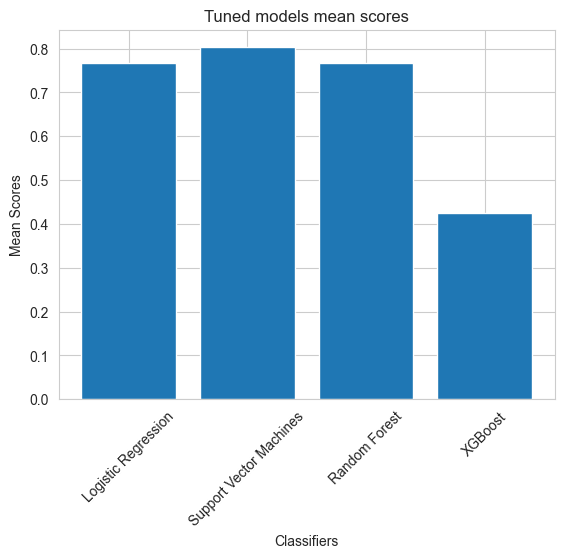

In [265]:
plt.bar(range(len(tuned_models_scores)), list(tuned_models_scores.values()), align='center')
plt.xticks(range(len(tuned_models_scores)), list(tuned_models_scores.keys()), rotation=45)
plt.xlabel('Classifiers')
plt.ylabel('Mean Scores')
plt.title('Tuned models mean scores')
plt.show()

Although SVM scored the highest score, it performed very poorly on the hispanic class

In [264]:
lr_pipe_scores = cross_validate(lr_model_grid, X_test, y_test, scoring=scoring)
svm_pipe_scores = cross_validate(svm_model_grid, X_test, y_test, scoring=scoring)

In [266]:
# caclculating the mean scores
results = {
    'Pipeline': ['Logistic Regression', 'SVM'],
    'F1_Hispanic': [lr_pipe_scores['test_f1_hespanic'].mean(), svm_pipe_scores['test_f1_hespanic'].mean()],
    'Precision_Hispanic': [lr_pipe_scores['test_precision_hespanic'].mean(), svm_pipe_scores['test_precision_hespanic'].mean()],
    'Recall_Hispanic': [lr_pipe_scores['test_recall_hespanic'].mean(), svm_pipe_scores['test_recall_hespanic'].mean()]
}
compare = pd.DataFrame(results)  # make it a dataframe
compare

Pipeline  F1_Hispanic  Precision_Hispanic  Recall_Hispanic
0  Logistic Regression     0.584588            0.501239         0.713757
1                  SVM     0.436980            0.296840         0.838360

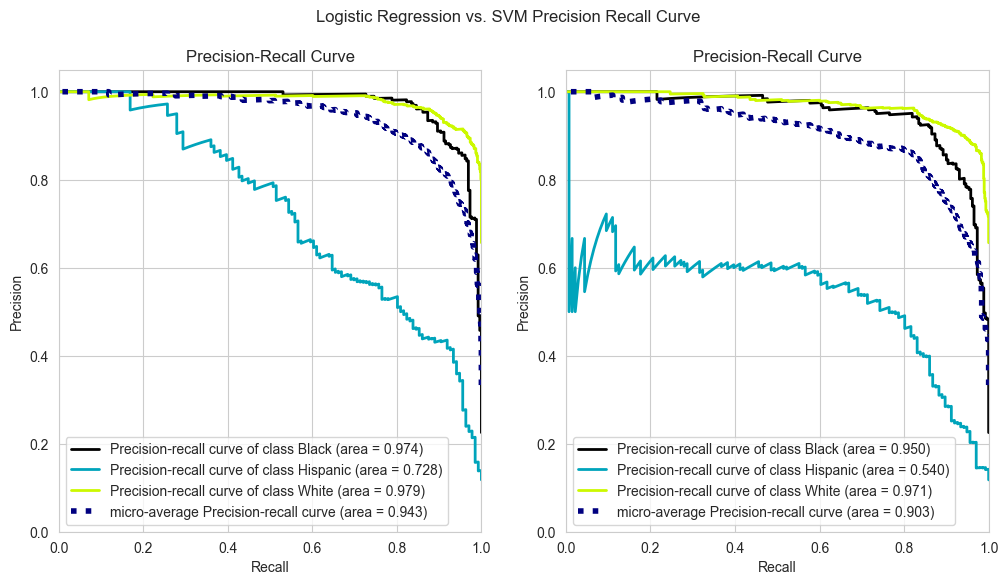

In [289]:
# displaying recall precision curves

y_pred_proba_lr = lr_model_grid.predict_proba(X_test)
y_pred_proba_svm = svm_model_grid.decision_function(X_test)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plot_precision_recall(y_test, y_pred_proba_lr, ax=axs[0])
plot_precision_recall(y_test, y_pred_proba_svm, ax=axs[1])


plt.suptitle('Logistic Regression vs. SVM Precision Recall Curve')
plt.show()

As we can see the logistic regression model has better scores for its classes compared to SVM. Therefore, legistic regression will be our final model.

---
---

---
---

# SMOTE

Trying to handle imbalanced classes using synthesize data to balance the minority class. <br>
Following the tutrioal provided in [2] 

##  Smote implement

In [300]:
oversampling = SMOTE( random_state = 2023)
undersampling = RandomUnderSampler(sampling_strategy = 'not minority', random_state = 2023)

## Logistic Regression Over/ Under Sampling

In [291]:
# make pipeline and pipeline cannot handle SMOTE so we are using the pipline from imblearn
from imblearn.pipeline import Pipeline as impip

In [312]:
# trying the oversampler
steps = [('transformer', column_trans), ('over', oversampling), ('scaler', sc),
         ('Tuned logistic Regression', LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                                                          random_state=2023, solver='sag'))]

lr_pipe_oversampling = impip(steps=steps)

lr_pipe_oversampling.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender',
                                                   'SubjectsBirthLocation',
                                                   'WritingPreference'])],
                                   verbose_feature_names_out=False)),
                ('over', SMOTE(random_state=2023)), ('scaler', MinMaxScaler()),
                ('Tuned logistic Regression',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                                    random_state=2023, solver='sag'))])

In [313]:
eval_metric(lr_pipe_oversampling, X_train, y_train, X_test, y_test)

Train_Set
[[ 948   47   43]
 [  30  426   87]
 [  54  301 2679]]
              precision    recall  f1-score   support

       Black       0.92      0.91      0.92      1038
    Hispanic       0.55      0.78      0.65       543
       White       0.95      0.88      0.92      3034

    accuracy                           0.88      4615
   macro avg       0.81      0.86      0.83      4615
weighted avg       0.90      0.88      0.88      4615


Test_Set
[[238  15   7]
 [  7 102  27]
 [ 20  72 666]]
              precision    recall  f1-score   support

       Black       0.90      0.92      0.91       260
    Hispanic       0.54      0.75      0.63       136
       White       0.95      0.88      0.91       758

    accuracy                           0.87      1154
   macro avg       0.80      0.85      0.82      1154
weighted avg       0.89      0.87      0.88      1154



In [322]:
scores = cross_validate(lr_pipe_oversampling,
                        X_train,
                        y_train,
                        scoring=recall_hespanic,
                        cv = 10,
                        n_jobs=-1,
                        return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_score     0.769832
train_score    0.818088
dtype: float64

In [324]:
# trying the undersampler
steps = [('transformer', column_trans), ('under', undersampling), ('scaler', sc),
         ('Tuned logistic Regression', LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                                                          random_state=2023, solver='sag'))]

lr_pipe_under= impip(steps=steps)

lr_pipe_under.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender',
                                                   'SubjectsBirthLocation',
                                                   'WritingPreference'])],
                                   verbose_feature_names_out=False)),
                ('under',
                 RandomUnderSampler(random_state=2023,
                                    sampling_strategy='not minority')),
                ('scaler', MinMaxScaler()),
                ('Tuned logistic Regression',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                                    random_state=2023, solver='sag'))])

In [316]:
eval_metric(lr_pipe_under, X_train, y_train, X_test, y_test)

Train_Set
[[ 945   48   45]
 [  32  437   74]
 [  75  420 2539]]
              precision    recall  f1-score   support

       Black       0.90      0.91      0.90      1038
    Hispanic       0.48      0.80      0.60       543
       White       0.96      0.84      0.89      3034

    accuracy                           0.85      4615
   macro avg       0.78      0.85      0.80      4615
weighted avg       0.89      0.85      0.86      4615


Test_Set
[[238  15   7]
 [  5 106  25]
 [ 30  92 636]]
              precision    recall  f1-score   support

       Black       0.87      0.92      0.89       260
    Hispanic       0.50      0.78      0.61       136
       White       0.95      0.84      0.89       758

    accuracy                           0.85      1154
   macro avg       0.77      0.84      0.80      1154
weighted avg       0.88      0.85      0.86      1154



In [325]:
scores = cross_validate(lr_pipe_under,
                        X_train,
                        y_train,
                        scoring=recall_hespanic,
                        cv = 10,
                        n_jobs=-1,
                        return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_score     0.769832
train_score    0.818088
dtype: float64

## Other Evaluation Metrics for Multiclass Classification

Testing other metrics for multiclass 

In [308]:
# tuned lr model
matthews_corrcoef(y_test, lr_model_grid.predict(X_test))

0.7632613068320363

In [326]:
# tuned lr model
matthews_corrcoef(y_test, lr_pipe_under.predict(X_test))

0.7319355194684002

In [319]:
cohen_kappa_score(y_test, lr_model_grid.predict(X_test))

0.7558956717294434

In [321]:
cohen_kappa_score(y_test, lr_pipe_oversampling.predict(X_test))

0.7232018791768676

# SHAP Analysis

In [268]:
lr_pipe.named_steps

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse_output=False),
                                  ['Gender', 'Component', 'Branch',
                                   'SubjectsBirthLocation',
                                   'WritingPreference'])],
                   verbose_feature_names_out=False),
 'minmaxscaler': MinMaxScaler(),
 'logisticregression': LogisticRegression()}

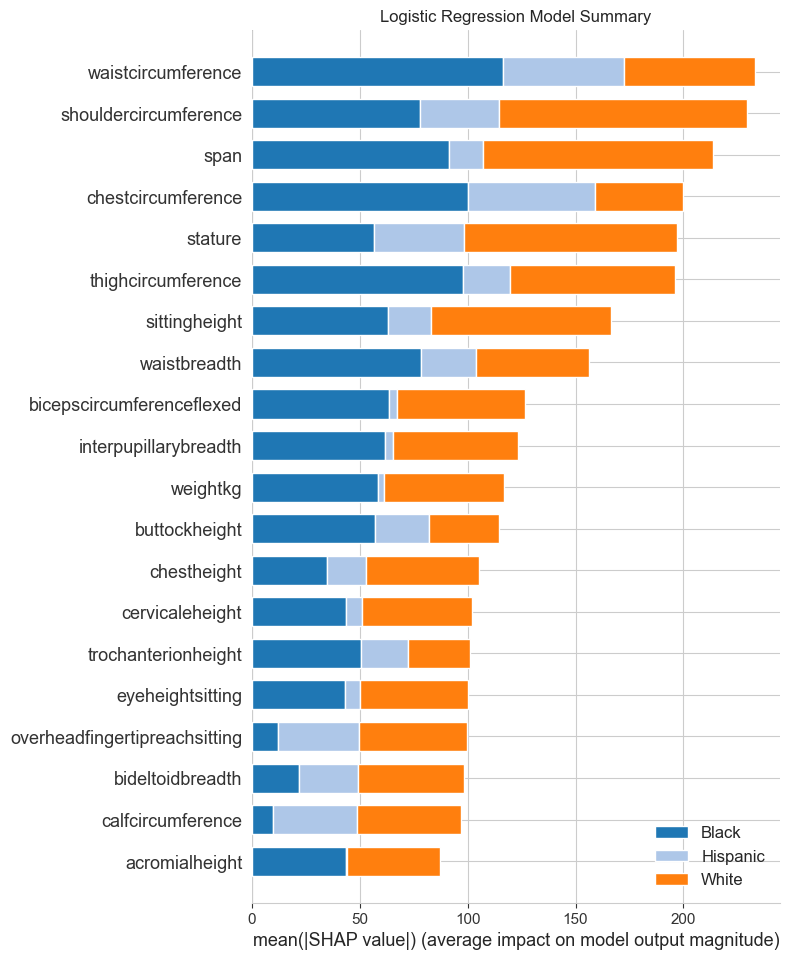

In [332]:
transformed_x = column_trans.fit_transform(X_train)
explainer = shap.Explainer(
    lr_pipe.named_steps.logisticregression, transformed_x)
shap_values = explainer.shap_values(transformed_x)

shap.summary_plot(shap_values, transformed_x, show=False,
                  class_names={0:'Black', 1:'Hispanic', 2:'White'},
                  class_inds='original',
                  color=plt.get_cmap('tab20'))
plt.title('Logistic Regression Model Summary')
plt.show()

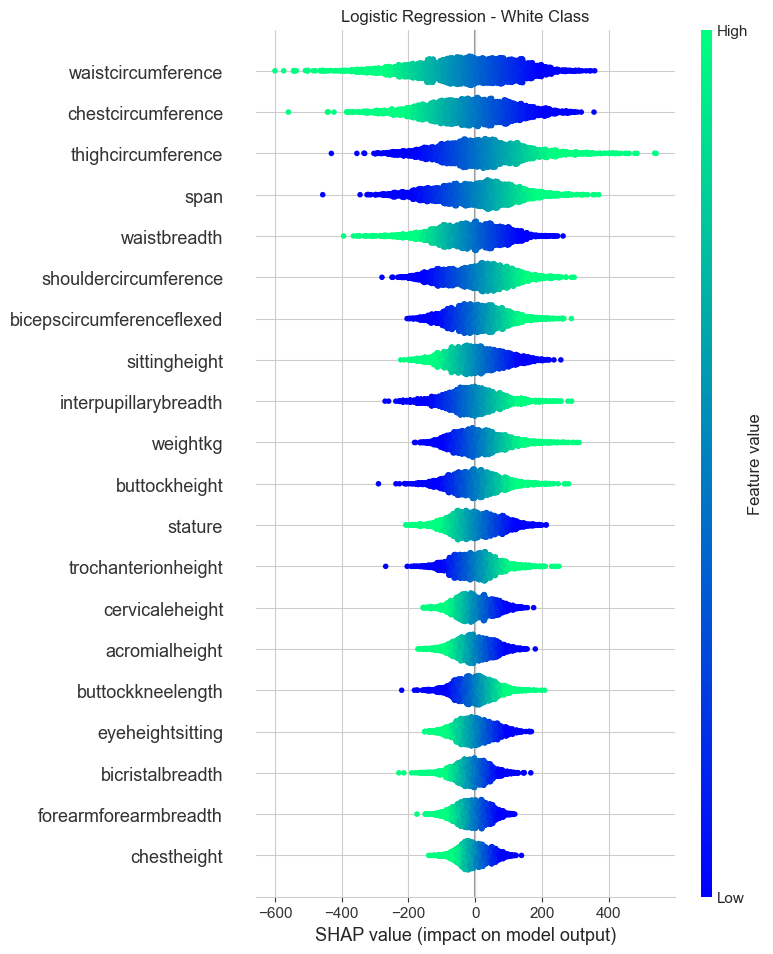

In [293]:
shap.summary_plot(shap_values[0], transformed_x, show=False, cmap=plt.get_cmap('winter'))
plt.title('Logistic Regression - Black Class')
plt.show()

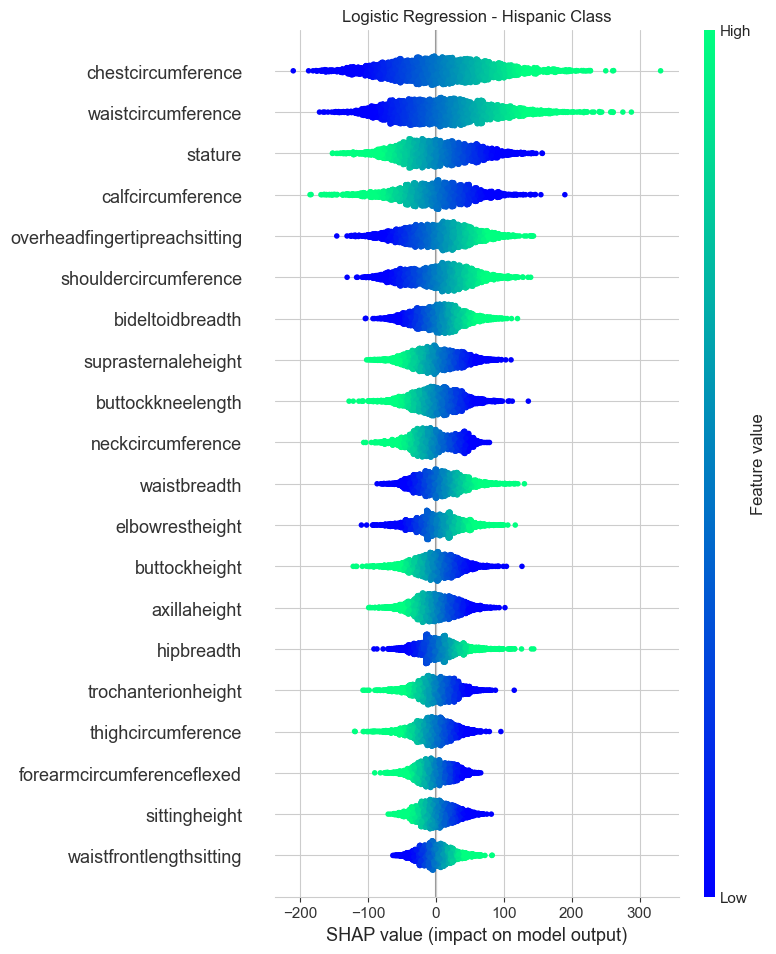

In [333]:
shap.summary_plot(shap_values[1], transformed_x, show=False, cmap=plt.get_cmap('winter'))
plt.title('Logistic Regression - Hispanic Class')
plt.show()

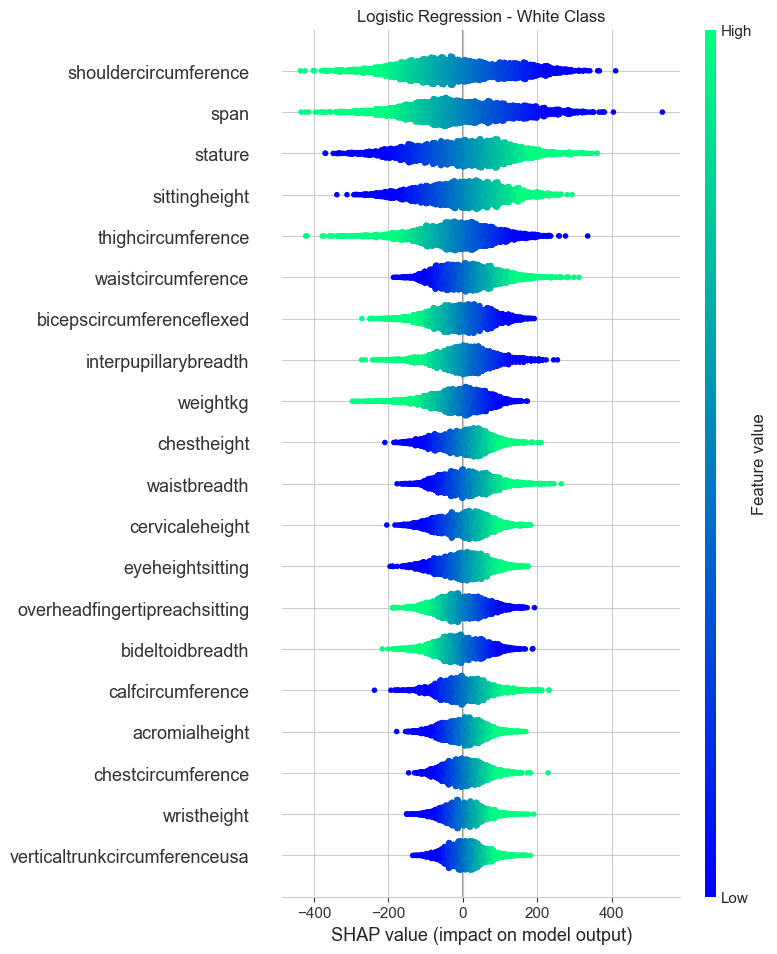

In [334]:
shap.summary_plot(shap_values[2], transformed_x, show=False, cmap=plt.get_cmap('winter'))
plt.title('Logistic Regression - White Class')
plt.show()

# Before the Deployment 
- Choose the model that works best based on your chosen metric
- For final step, fit the best model with whole dataset to get better performance.
- And your model ready to deploy, dump your model and scaler.

## Results discussion

## References

[1] https://data.world/datamil/ansur-ii-data-dictionary/workspace/file?filename=ANSUR+II+Databases+Overview.pdf <br>
[2] https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/ <br>
[3] fitting sample_weight in pipeline issue fix https://github.com/scikit-learn/scikit-learn/issues/18159 <br>
[4] Evaluation metrics https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd <br>
[5] SHAP analysis https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___